# RESUMO:
* [BIBLIOTECAS](#titulo_1)
* [BASE DE TRABALHO](#titulo_2)
    * [Importação da Base](#subtitulo_2.1)
    * [Preenchimento de Vazios](#subtitulo_2.2)
* [ANÁLISE EXPLORATÓRIA (EDA)](#titulo_3)
    * [Distribuição das Variáveis](#subtitulo_3.2)
    * [Relação Entre as Variáveis](#subtitulo_3.3)
* [PRÉ-PROCESSAMENTO DE DADOS](#titulo_4)
    * [Transformação de Variáveis Categóricas](#subtitulo_4.1)
    * [Normalização dos Dados](#subtitulo_4.2)
    * [Separação das Bases de Treino e Teste](#subtitulo_4.3)
    * [Balanceamento da Base de Treino](#subtitulo_4.4)
* [CRIAÇÃO DOS MODELOS DE ML](#titulo_5)
    * [Modelos Sem Otimização](#subtitulo_5.1)
    * [Modelos Com Otimização](#subtitulo_5.2)
        * [Árvore de Decisão](#subtitulo_5.2.1)
        * [Random Forest](#subtitulo_5.2.2)
        * [XGBoost](#subtitulo_5.2.3)

## BIBLIOTECAS <a class="anchor" id="titulo_1"></a>

### Tratamento e Pré-Processamento de dados

In [1]:
import numpy as np
import pandas as pd

from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTENC

import warnings
import urllib3

### Construção dos Modelos de ML

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
# from lightgbm import LGBClassifier
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score
from sklearn.metrics import auc, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, plot_roc_curve
from sklearn import model_selection
import eli5
from sklearn.model_selection import GridSearchCV
from eli5.sklearn import PermutationImportance

## BASE DE TRABALHO <a class="anchor" id="titulo_2"></a>

### Origem da Base
[Kaggle] Telecom Customer Churn Prediction
* Kaggle Grade Usability: 10.0
* Membro: Shi Long Zhuang (Kaggle Datasets Expert)
* Origem: Maven Analytics
* A tabela contém informações sobre todos os 7.043 clientes de uma empresa de telecomunicações na Califórnia no segundo trimestre de 2022
* Link: https://www.kaggle.com/datasets/shilongzhuang/telecom-customer-churn-by-maven-analytics

In [3]:
# Desabilitar Warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

In [4]:
df = pd.read_excel(r'C:\Users\lucas\Desktop\UERJ\TCC\Modelo\Bases\[Kaggle] Telecom_Churn_Shi_Long\descricao_variaveis.xlsx')
# df = pd.read_excel(r'C:\Users\luharita\Desktop\TCC\Modelo\Bases\[Kaggle] Telecom_Churn_Shi_Long\descricao_variaveis.xlsx')
df = df.sort_values(['Variável'],ascending=[True])
df.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])]).\
                            set_properties(**{'text-align': 'center'}).\
                            set_properties(subset=['Descrição'], **{'width': '300px'}).\
                            set_properties(subset=['Tipo Esperado'], **{'width': '180px'}).\
                            set_properties(subset=['Valores Esperados'], **{'width': '180px'}).\
                            hide_index()

Variável,Descrição,Tipo Esperado,Valores Esperados
Age,Idade do cliente em anos,Inteiro,1 a 120
Avg Monthly GB Download,Volume médio de download do cliente em GB,Decimal,0-100000
Avg Monthly Long Distance Charges,Tarifa média de longa distância do cliente,Decimal,0-100000
Churn Category,Motivo da saída do cliente,Texto (Categórico),Motivos
Churn Reason,Detalhe do motivo da saída do cliente,Texto (Categórico),Motivos
City,Cidade onde o cliente mora,Texto (Categórico),Cidades
Contract,"Tipo de contrato atual do cliente (mensal, anual, etc)",Texto (Categórico),Mensal/Anual/Semestral
Customer Status,"Status atual do cliente (Churned, Stayed ou Joined)",Texto (Categórico),Churned/Stayed/Joined
CustomerID,Valor único que identifica cada cliente,Inteiro,0-100000000
Device Protection Plan,Indica se o cliente assina um serviço de proteção de um dispositivo adicional,Texto (Categórico),Sim/Não


### Importação da Base <a class="anchor" id="subtitulo_2.1"></a>

In [5]:
# Ler arquivo
base_hist = pd.read_csv(r'C:\Users\lucas\Desktop\UERJ\TCC\Modelo\Bases\[Kaggle] Telecom_Churn_Shi_Long\telecom_customer_churn.csv', sep=',', decimal='.', encoding='utf-8-sig')
# base_hist = pd.read_csv(r'C:\Users\luharita\Desktop\TCC\Modelo\Bases\[Kaggle] Telecom_Churn_Shi_Long\telecom_customer_churn.csv', sep=',', decimal='.', encoding='utf-8-sig')

# Filtrar dados
# base_hist = base_hist[base_hist['churn'].notnull()]
base_hist = base_hist.reset_index().drop(['index'], axis = 1)

# Arrumar nome das colunas
base_hist.columns = base_hist.columns.str.replace(" ","_").str.lower()

# Resumo
# base_hist.info()
base_hist.head()

,customer_id,gender,age,married,number_of_dependents,city,zip_code,latitude,longitude,number_of_referrals,...,payment_method,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,customer_status,churn_category,churn_reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


### Preenchimento de Vazios <a class="anchor" id="subtitulo_2.2"></a>

In [6]:
# Função para verificar % de valores vazios
def contar_vazios(dataframe):
    qtd_col_vazio = 0
    for col in dataframe.columns[1:]:
        if base_hist[col].isna().sum() > 0:
            perc = round((base_hist[col].isna().sum()/base_hist[col].isna().count())*100,1).astype('str')
            tipo = ''
            if base_hist.dtypes[col] == np.object:
                tipo = 'object'
            if base_hist.dtypes[col] == np.int64:
                 tipo = 'int64'
            if base_hist.dtypes[col] == np.float64:
                 tipo = 'float64'
            print((col + ' ------------------------------------')[:45] + ' ' + (perc + '% ----------')[:10] + ' ' + tipo)
            qtd_col_vazio += 1
    print('{} colunas com campos vazios.'.format(qtd_col_vazio))

# Rodar função
contar_vazios(base_hist)

avg_monthly_long_distance_charges ----------- 9.7% ----- float64
multiple_lines ------------------------------ 9.7% ----- object
internet_type ------------------------------- 21.7% ---- object
avg_monthly_gb_download --------------------- 21.7% ---- float64
online_security ----------------------------- 21.7% ---- object
online_backup ------------------------------- 21.7% ---- object
device_protection_plan ---------------------- 21.7% ---- object
premium_tech_support ------------------------ 21.7% ---- object
streaming_tv -------------------------------- 21.7% ---- object
streaming_movies ---------------------------- 21.7% ---- object
streaming_music ----------------------------- 21.7% ---- object
unlimited_data ------------------------------ 21.7% ---- object
churn_category ------------------------------ 73.5% ---- object
churn_reason -------------------------------- 73.5% ---- object
14 colunas com campos vazios.


#### Análise dos vazios

Chama atenção que o percentual de vazios parece seguir a uma tendência. Entre as 14 variáveis só temos 3 percentuais diferentes, o que nos leva a pensar que essas variáveis possuem uma correlação entre si e possivelmente uma razão para estarem vazias.

In [7]:
# VARIÁVEIS COM 9,7% VAZIO
colunas_vazias = ['avg_monthly_long_distance_charges','multiple_lines']
base_hist_sem_vazios = base_hist.dropna(subset=colunas_vazias)
qtd_unicos = pd.DataFrame(base_hist_sem_vazios.nunique())

# Identificar variáveis com apenas 1 valor único
print(qtd_unicos[qtd_unicos[0]<=1])

               0
phone_service  1


In [8]:
print('Base sem vazios:')
print(base_hist_sem_vazios['phone_service'].unique())

base_hist_apenas_vazios = base_hist[(base_hist['avg_monthly_long_distance_charges'].isna() | base_hist['multiple_lines'].isna())]
print('Base apenas vazios:')
print(base_hist_apenas_vazios['phone_service'].unique())

Base sem vazios:
['Yes']
Base apenas vazios:
['No']


In [9]:
base_teste = base_hist[base_hist['internet_service'] == 'Yes']

In [10]:
base_teste['internet_type'].unique()

array(['Cable', 'Fiber Optic', 'DSL'], dtype=object)

In [11]:
base_teste['avg_monthly_gb_download'].isnull().sum()

0

In [12]:
base_teste['avg_monthly_gb_download'].min()

2.0

In [13]:
# VARIÁVEIS COM 21,7% VAZIO
colunas_vazias = ['internet_type', 'avg_monthly_gb_download','online_security','online_backup','device_protection_plan',
                  'premium_tech_support','streaming_tv','streaming_movies','streaming_music','unlimited_data']
base_hist_sem_vazios = base_hist.dropna(subset=colunas_vazias)
qtd_unicos = pd.DataFrame(base_hist_sem_vazios.nunique())

# Identificar variáveis com apenas 1 valor único
print(qtd_unicos[qtd_unicos[0]<=1])

                  0
internet_service  1


In [14]:
print('Base sem vazios:')
print(base_hist_sem_vazios['internet_service'].unique())

base_hist_apenas_vazios = base_hist[(base_hist['internet_type'].isna()
                                     | base_hist['avg_monthly_gb_download'].isna() | base_hist['online_security'].isna()
                                     | base_hist['online_backup'].isna() | base_hist['device_protection_plan'].isna()
                                     | base_hist['premium_tech_support'].isna() | base_hist['streaming_tv'].isna()
                                     | base_hist['streaming_movies'].isna() | base_hist['streaming_music'].isna()
                                     | base_hist['unlimited_data'].isna())]
print('Base apenas vazios:')
print(base_hist_apenas_vazios['internet_service'].unique())

Base sem vazios:
['Yes']
Base apenas vazios:
['No']


In [15]:
# VARIÁVEIS COM 73,5% VAZIO
colunas_vazias = ['churn_category', 'churn_reason']
base_hist_sem_vazios = base_hist.dropna(subset=colunas_vazias)
qtd_unicos = pd.DataFrame(base_hist_sem_vazios.nunique())

# Identificar variáveis com apenas 1 valor único
print()
print(qtd_unicos[qtd_unicos[0]<=1])


                 0
customer_status  1


In [16]:
print('Base sem vazios:')
print(base_hist_sem_vazios['customer_status'].unique())

base_hist_apenas_vazios = base_hist[(base_hist['churn_category'].isna() | base_hist['churn_reason'].isna())]
print('Base apenas vazios:')
print(base_hist_apenas_vazios['customer_status'].unique())

Base sem vazios:
['Churned']
Base apenas vazios:
['Stayed' 'Joined']


#### CONCLUSÃO:
* As duas variáveis com 9,7% de valores vazios são consequência da variável phone_service igual a "No"
* As onze variáveis com 21,7% de valores vazios são consequência da variável internet_service igual a "No"
* As duas variáveis com 73,5% de valores vazios são consequência da variável customer_status diferente de "Churned"

#### Preencher valores vazios

In [17]:
# Preencher valores vazios

# Int e Float
base_hist['avg_monthly_long_distance_charges'].fillna(0, inplace = True)
base_hist['avg_monthly_gb_download'].fillna(0, inplace = True)

# Object
base_hist['multiple_lines'].fillna('No', inplace = True)
base_hist['internet_type'].fillna('None', inplace = True)
base_hist['online_security'].fillna('No', inplace = True)
base_hist['online_backup'].fillna('No', inplace = True)
base_hist['device_protection_plan'].fillna('No', inplace = True)
base_hist['premium_tech_support'].fillna('No', inplace = True)
base_hist['streaming_tv'].fillna('No', inplace = True)
base_hist['streaming_movies'].fillna('No', inplace = True)
base_hist['streaming_music'].fillna('No', inplace = True)
base_hist['unlimited_data'].fillna('No', inplace = True)
base_hist['churn_category'].fillna('No', inplace = True)
base_hist['churn_reason'].fillna('No', inplace = True)
#base_hist['avg_monthly_long_distance_charges'].fillna(base_hist['taxa_saida_cpf_12m'].mean(), inplace = True)

# Checar se todas as colunas estão preenchidas
contar_vazios(base_hist)

0 colunas com campos vazios.


### Criação da Variável Target

<AxesSubplot:ylabel='customer_status'>

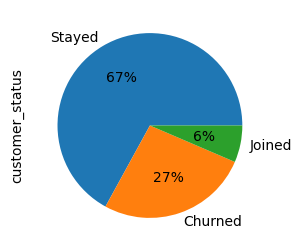

In [18]:
# Distribuição Atual
base_hist['customer_status'].value_counts().plot(kind='pie', y='perc', autopct='%1.0f%%', figsize = (3, 3))

In [19]:
# Excluir clientes recentes para não ter viés de tempo na saída do cliente
base_hist = base_hist[base_hist['customer_status'].str.contains('Joined') == False]
base_hist.reset_index(drop=True,inplace=True)

# Criar variável target de churn
base_hist['churn'] = np.where(base_hist['customer_status'].str.contains('Churned'), 1, 0)

<AxesSubplot:ylabel='customer_status'>

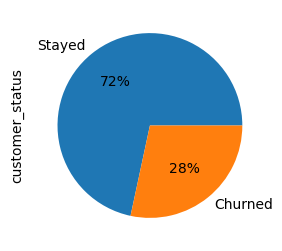

In [20]:
# Nova Distribuição
base_hist['customer_status'].value_counts().plot(kind='pie', y='perc', autopct='%1.0f%%', figsize = (3, 3))

## ANÁLISE EXPLORATÓRIA (EDA) <a class="anchor" id="titulo_3"></a>

In [21]:
# report = ProfileReport(base_hist)
# report

### Distribuição das Variáveis <a class="anchor" id="subtitulo_3.2"></a>

In [22]:
# Criar base para EDA
base_hist_eda = base_hist.copy()

# Variável Target
base_hist_eda['churn'] = base_hist_eda['churn'].apply(
                                lambda x:'Yes' if x > 0 else 'No')

#### Variáveis Categóricas

In [23]:
# Função para criar as tabelas
def criar_tabela_comp(base, variavel, target):
    linhas = len(base.index)
    df = (pd.crosstab(base_hist_eda[variavel],base_hist_eda[target],margins=True)/linhas).round(3)*100
    df['% ' + target] = (df['Yes']/(df['Yes']+df['No'])).round(3)*100
    return df

In [24]:
# Sexo
criar_tabela_comp(base_hist_eda,'gender','churn')

churn,No,Yes,All,% churn
gender,,,,
Female,35.5,14.3,49.7,28.7
Male,36.2,14.1,50.3,28.0
All,71.6,28.4,100.0,28.4


A variável sexo não parece ter muita correlação com o churn, temos uma representatividade muito parecida de cada sexo dentro da base e o % de churn também é praticamente o mesmo.

In [25]:
# Estado civil casado
criar_tabela_comp(base_hist_eda,'married','churn')

churn,No,Yes,All,% churn
married,,,,
No,31.4,18.2,49.6,36.7
Yes,40.2,10.2,50.4,20.2
All,71.6,28.4,100.0,28.4


Já na variável de estado civil, vemos que os clientes casados tem uma representatividade muito similar aos não casados, porém possuem um % de churn bem inferior, uam diferença de 16p.p.

In [26]:
# Ofertas
criar_tabela_comp(base_hist_eda,'offer','churn')

churn,No,Yes,All,% churn
offer,,,,
None,38.7,16.0,54.6,29.3
Offer A,7.4,0.5,7.9,6.3
Offer B,11.0,1.5,12.5,12.0
Offer C,4.9,1.4,6.3,22.2
Offer D,6.7,2.4,9.1,26.4
Offer E,3.1,6.5,9.6,67.7
All,71.6,28.4,100.0,28.4


Entre as classes de oferta, vemos que a maior parte da base não recebeu nenhuma oferta e os grupos que mais chamam atenção são:
* Oferta A: Poucos clientes deram churn, o que pode ser um indício de que é uma boa maneira de "segurar" os clientes
* Oferta E: Já nesse oferta a maior parte dos clientes acabou saindo, o que nos mostra que não foi uma oferta que o cliente enxergou muito valor

In [27]:
# Serviço de telefone
criar_tabela_comp(base_hist_eda,'phone_service','churn')

churn,No,Yes,All,% churn
phone_service,,,,
No,7.2,2.6,9.8,26.5
Yes,64.4,25.8,90.2,28.6
All,71.6,28.4,100.0,28.4


Mais de 90% da base possui serviço de celular e o % de churn não varia muito entre pessoas com e sem esse serviço.

In [28]:
# Múltiplas linhas de telefone
criar_tabela_comp(base_hist_eda,'multiple_lines','churn')

churn,No,Yes,All,% churn
multiple_lines,,,,
No,40.1,15.5,55.6,27.9
Yes,31.5,12.9,44.4,29.1
All,71.6,28.4,100.0,28.4


Como vimos anteriormente, os clientes com o campo multiple_lines vazio são consequência do fato de não terem um serviço de celular. Para os que possuem esse serviço, por volta da metade possui múltiplas linhas e o % de churn é praticamente o mesmo entre esses dois grupos.

In [29]:
# Serviço de Internet
criar_tabela_comp(base_hist_eda,'internet_service','churn')

churn,No,Yes,All,% churn
internet_service,,,,
No,18.7,1.7,20.4,8.3
Yes,53.0,26.7,79.6,33.5
All,71.6,28.4,100.0,28.4


Por volta de 80% da base possui serviço de internet. Aqui vemos algo que chama bastante atenção, os clientes com serviço de internet possuem um % de churn praticamente 4 vezes maior que aqueles não possuem esse serviço.

In [30]:
base_hist_eda['service'] = np.where(((base_hist_eda['internet_service'] == 'Yes') & (base_hist_eda['phone_service'] == 'Yes')), 'internet + phone',
                                                np.where(base_hist_eda['internet_service'] == 'Yes', 'only internet',
                                                        np.where(base_hist_eda['phone_service'] == 'Yes', 'only phone','-')))

In [31]:
# Serviço de Internet + Telefonia
criar_tabela_comp(base_hist_eda,'service','churn')

churn,No,Yes,All,% churn
service,,,,
internet + phone,45.8,24.1,69.8,34.5
only internet,7.2,2.6,9.8,26.5
only phone,18.7,1.7,20.4,8.3
All,71.6,28.4,100.0,28.4


Dos 20% que só possuem serviço de telefonia, o churn é muito inferior.

In [32]:
# Tipo de contrato (recorrência)
criar_tabela_comp(base_hist_eda,'contract','churn')

churn,No,Yes,All,% churn
contract,,,,
Month-to-Month,23.5,25.1,48.6,51.6
One Year,20.6,2.5,23.2,10.8
Two Year,27.5,0.7,28.2,2.5
All,71.6,28.4,100.0,28.4


Por volta de metade dos clientes possui um contrato mensal, sendo que esse grupo de clientes possui um % de churn muito acima dos contratos anuais, chegando a ser 5 vezes superior.

In [33]:
# Forma de pagamento
criar_tabela_comp(base_hist_eda,'payment_method','churn')

churn,No,Yes,All,% churn
payment_method,,,,
Bank Withdrawal,36.4,20.2,56.6,35.7
Credit Card,32.2,6.0,38.2,15.7
Mailed Check,3.1,2.2,5.2,41.5
All,71.6,28.4,100.0,28.4


A maior parte dos clientes possui pagamento via débito automático e os clientes com essa forma de pagamento possuem um churn bem acima da média da base, em detrimento dos clientes que pagam por cartão de crédito e possuem um % de churn bem inferior.

In [34]:
# Cidade
linhas = len(base_hist_eda.index)
df = (pd.crosstab(base_hist_eda['city'],base_hist_eda['churn'],margins=True)/linhas).round(3)*100
df['% ' +'churn'] = (df['Yes']/(df['Yes']+df['No'])).round(3)*100

print('Quantidade de cidades diferentes: ' + str(len(base_hist_eda['city'].unique())))
#df = df[df['churn'] "=" 'All']
#df['city']
df.sort_values(['All'],ascending=[False]).head(10)

Quantidade de cidades diferentes: 1106


churn,No,Yes,All,% churn
city,,,,
All,71.6,28.4,100.0,28.4
San Diego,1.4,2.8,4.2,66.7
Los Angeles,3.0,1.2,4.2,28.6
San Jose,1.2,0.4,1.7,25.0
San Francisco,1.0,0.5,1.5,33.3
Sacramento,1.2,0.4,1.5,25.0
Long Beach,0.7,0.2,0.9,22.2
Fresno,0.7,0.2,0.9,22.2
Oakland,0.5,0.2,0.7,28.6


É possível verificar que:
- Na variável de cidade temos uma dispersão muito grande, com 1.106 valores distintos
- As 2 cidades mais representativas, equivalem a apenas 4% da base cada uma, a terceira cidade já representa menos que 2%
- O comportamento em relação ao churn chama atenção apenas em San Diego, com uma média mais que 2x maior que da base

Tratamento:
- Criar uma nova variável com a informação de cidade quando for San Diego ou "Outros", dado que as outras cidades só trariam uma complexidade muito mais alta para o modelo

### 🔴 <font color='red'>IMPORTANTE</font>
- Alterar fundo dos gráficos para a cor branca

#### Variáveis Quantitativas - Contínuas

In [35]:
# Personalização dos gráficos
sb.set(style='darkgrid')
sb.set(rc={'figure.figsize':(12,3)})
sb.set(rc={'axes.facecolor':'white', 'grid.color': '.91'})
            
# Função para criar gráficos com seaborn kdeplot
def gerar_graficos_var_cont(coluna):
    fig, ax = plt.subplots(1,3)
    sb.kdeplot(base_hist_eda[coluna], shade=True, color='royalblue', ax=ax[0]).set(title='Distribuição')
    sb.kdeplot(data=base_hist_eda, x=coluna, hue="churn", multiple="stack", ax=ax[1]).set(title='Densidade x Churn')
    sb.boxplot(data=base_hist_eda, x="churn", y=coluna, ax=ax[2]).set(title='Boxplot x Churn')
    return fig.show()

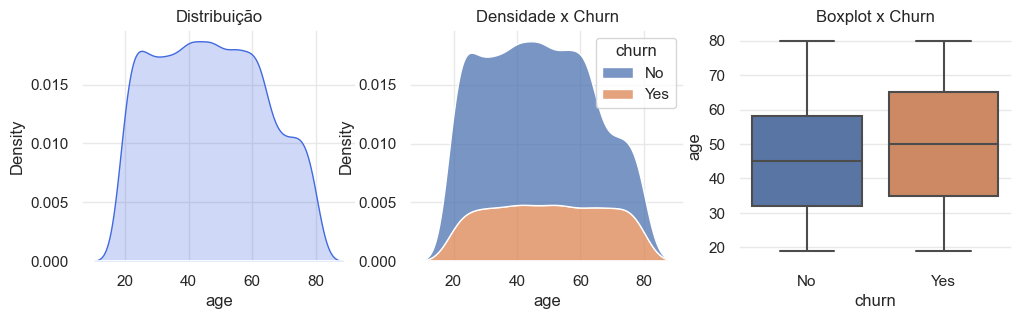

In [36]:
# Idade
gerar_graficos_var_cont('age')

Distribuição:
        <li>Percebe-se uma concentração em clientes de 20 a 60 anos.</li>
    </ul></li></br>
Relação com o Churn:
        <li>A idade do indivíduo parece ter uma leve relação com o churn: indivíduos mais velhos possuem um % de churn bastante acima da média, principalmente aqueles com idade superior a 60 anos </li>

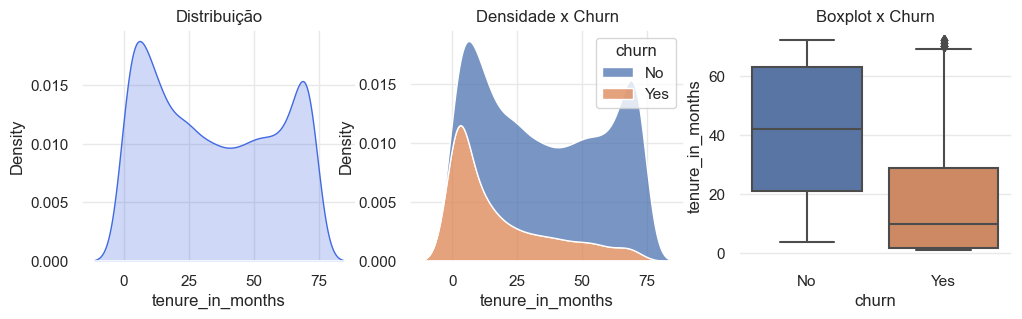

In [37]:
# Tempo de Casa (Meses)
gerar_graficos_var_cont('tenure_in_months')

Distribuição:
        <li>Os clientes estão bem distribuídos em relação ao tempo de casa, tendo maiores concentrações em clientes com 0-6 meses e clientes com 60-70 meses.</li>
    </ul></li></br>
Relação com o Churn:
        <li>Chama atenção o alto índice de churn em clientes com pouco tempo de casa, parece existir uma tendência.</li>

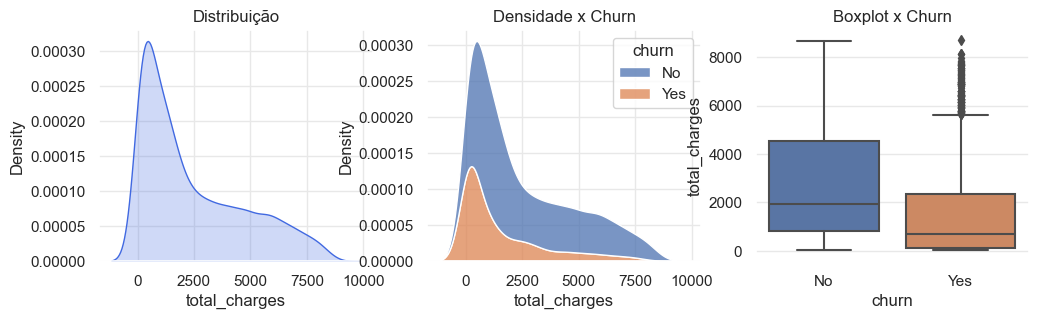

In [38]:
# Cobranças Totais
gerar_graficos_var_cont('total_charges')

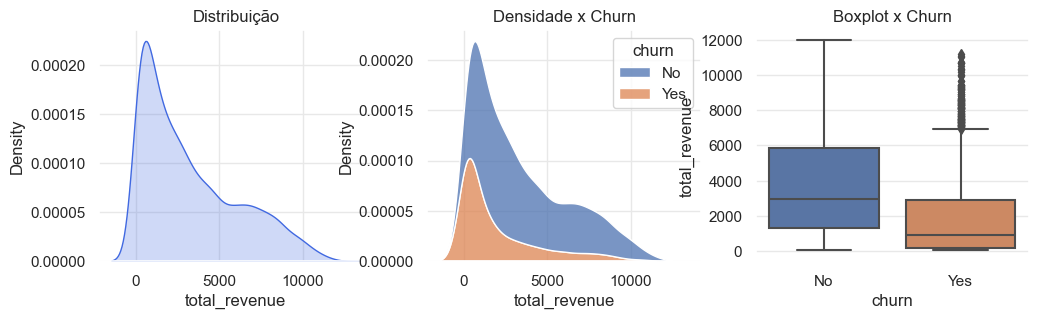

In [39]:
# Receita Total
gerar_graficos_var_cont('total_revenue')

Distribuição:
        <li>Forte concentração em clientes com receita (ou valor total cobrado) baixa ou igual a zero.</li>
    </ul></li></br>
Relação com o Churn:
        <li>O % de churn é muito superior nos clientes com pouca ou nenhuma receita (ou valor total cobrado).</li>

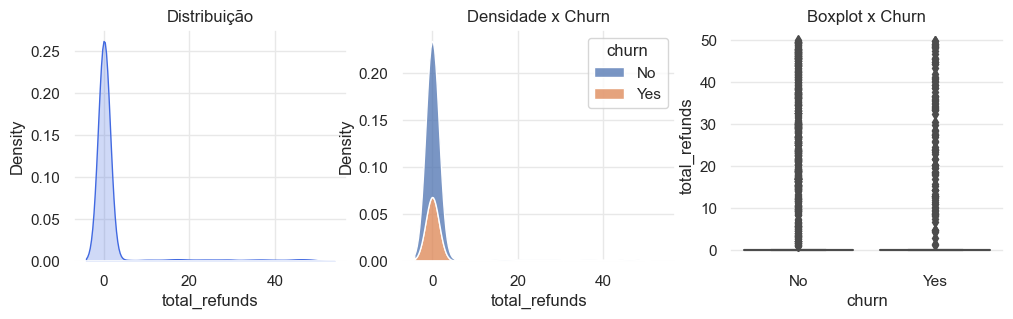

In [40]:
# Valor Reembolsado
gerar_graficos_var_cont('total_refunds')

Distribuição:
        <li>A maior parte da base de clientes não possui valor reembolsado.</li>
    </ul></li></br>
Relação com o Churn:
        <li>Difícil concluir relações com o churn, dado que a distribuição possui uma concentração muito alta em clientes sem valor reembolsado.</li>

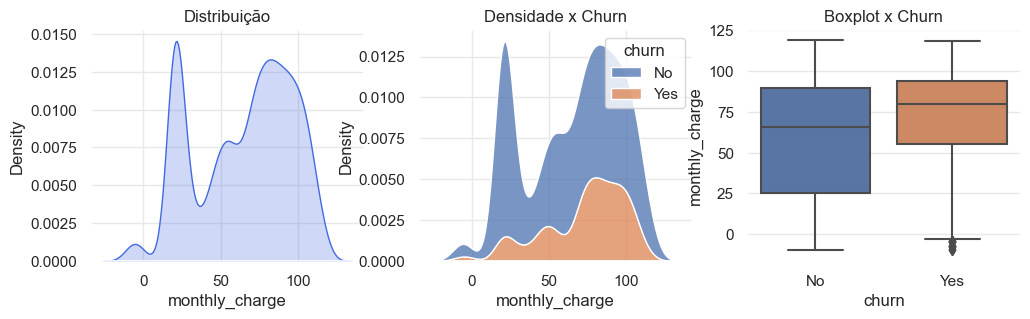

In [41]:
# Valor Mensal Cobrado
gerar_graficos_var_cont('monthly_charge')

Distribuição:
        <li>A maior concentração é em clientes com ticket médios mais baixos.</li>
    </ul></li></br>
Relação com o Churn:
        <li>Chama atenção o baixo % de churn na faixa de clientes com ticket médio mais baixo.</li>

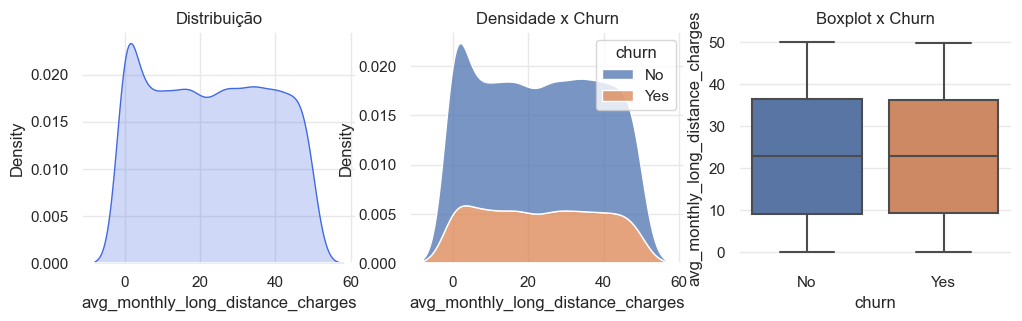

In [42]:
# Tarifa Média de Longa Distância do Cliente
gerar_graficos_var_cont('avg_monthly_long_distance_charges')

Distribuição:
        <li>Os clientes estão bem distribuídos em relação à tarifa média de longa distância, tendo maiores concentrações em clientes com R$0-R$5.</li>
    </ul></li></br>
Relação com o Churn:
        <li>Não parece existir uma tendência clara entre essa variável e o Churn.</li>

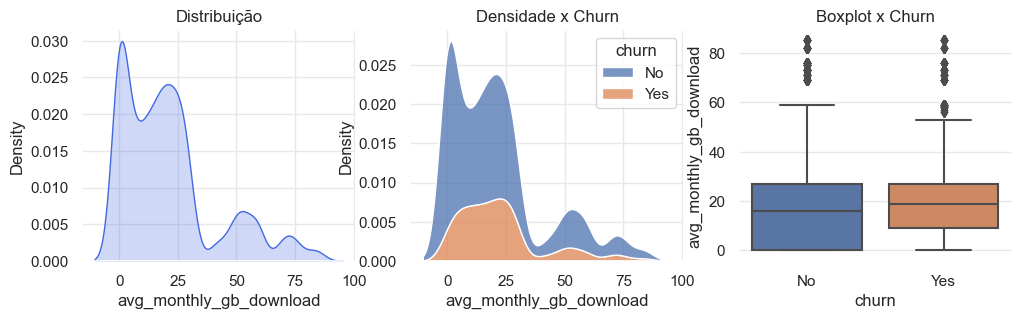

In [43]:
# Volume Médio de Download do Cliente em GB
gerar_graficos_var_cont('avg_monthly_gb_download')

Distribuição:
        <li>Existe uma concentração em clientes com menos de 25GB consumidos via download.</li>
    </ul></li></br>
Relação com o Churn:
        <li>Parece existir uma leve correlação entre essa variável e o Churn, clientes com menos downloads parecem sair um pouco menos em relação ao todo.</li>

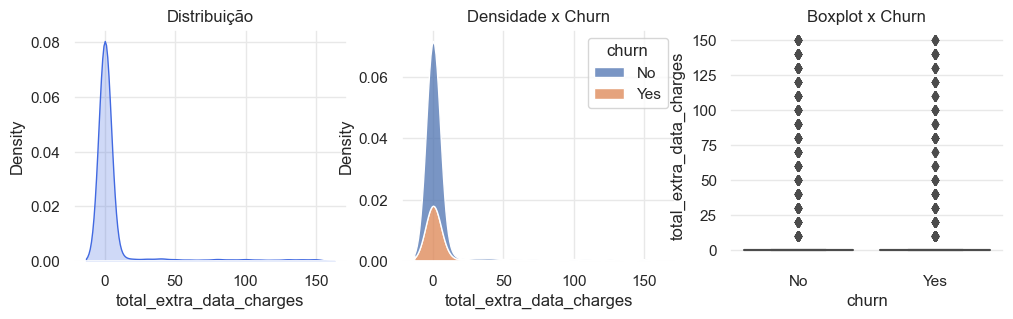

In [44]:
# Valor Total Cobrado por Downloads Acima do Limite
gerar_graficos_var_cont('total_extra_data_charges')

Distribuição:
        <li>A maior parte da base de clientes não possui valor cobrado por downloads acima do limite.</li>
    </ul></li></br>
Relação com o Churn:
        <li>Difícil concluir relações com o churn, dado que a distribuição possui uma concentração muito alta em clientes sem nenhum valor cobrado por downloads acima do limite.</li>

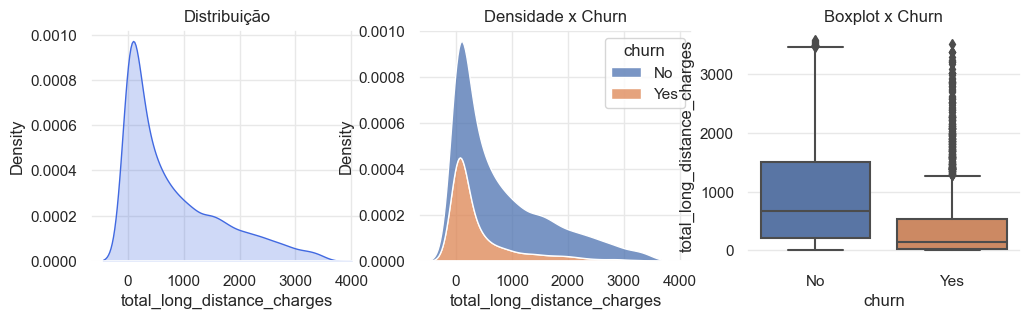

In [45]:
# Valor Total Cobrado por Ligações de Longa Distância Acima do Limite
gerar_graficos_var_cont('total_long_distance_charges')

Distribuição:
        <li>Forte concentração em clientes com valor cobrado baixo ou igual a zero.</li>
    </ul></li></br>
Relação com o Churn:
        <li>O % de churn é muito superior nos clientes com pouca ou nenhum valor cobrado.</li>

#### Variáveis Quantitativas - Discretas

In [46]:
# Personalização dos gráficos
sb.set(style='darkgrid')
sb.set(rc={'figure.figsize':(12,3)})
sb.set(rc={'axes.facecolor':'white', 'grid.color': '.91'})

# Função para criar gráficos com seaborn kdeplot
def gerar_graficos_var_disc(coluna):
    fig, ax = plt.subplots(1,3)
    sb.countplot(data=base_hist_eda, x=coluna, color='royalblue', ax=ax[0]).set(title='Distribuição')
    sb.countplot(data=base_hist_eda, x=coluna, hue="churn", ax=ax[1]).set(title='Distribuição x Churn')
    sb.boxplot(data=base_hist_eda, x="churn", y=coluna, ax=ax[2]).set(title='Boxplot x Churn')
    return fig.show()

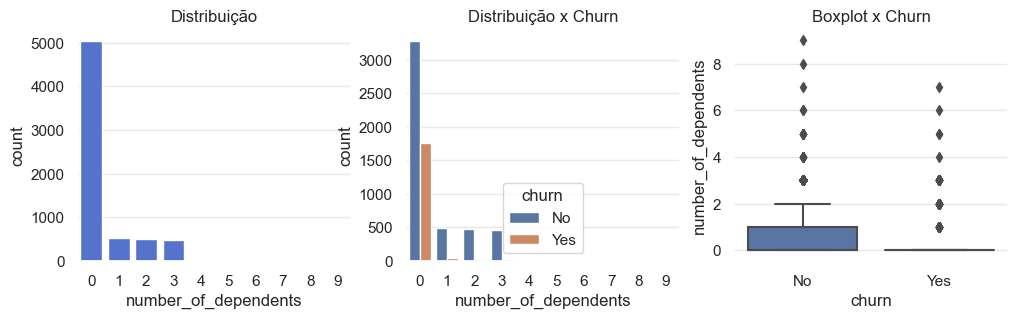

In [47]:
# Número de Dependentes
gerar_graficos_var_disc('number_of_dependents')

Distribuição:
        <li>A maior parte da base de clientes não possui dependentes.</li>
    </ul></li></br>
Relação com o Churn:
        <li>Pode-se notar uma leve tendência de clientes com dependentes saírem menos. Mas é difícil ter uma avaliação conclusiva em relação ao churn, dado que a distribuição possui uma concentração muito alta em clientes sem dependentes.</li>

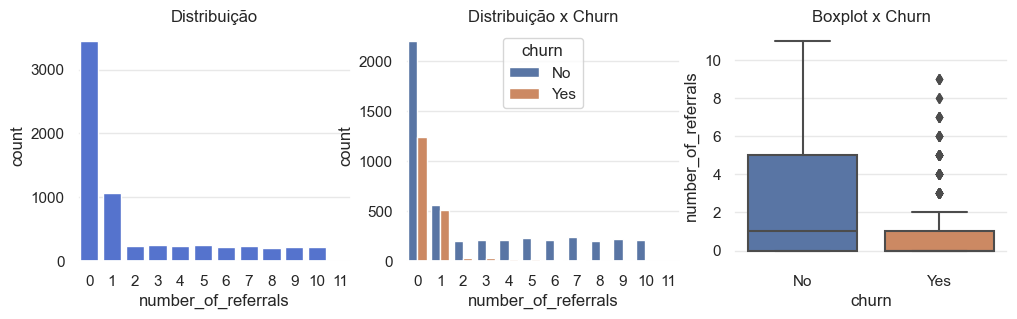

In [48]:
# Número de Indicações
gerar_graficos_var_disc('number_of_referrals')

Distribuição:
        <li>A maior parte da base de clientes não possui indicações feitas.</li>
    </ul></li></br>
Relação com o Churn:
        <li>Pode-se notar uma leve tendência de clientes com 2 ou mais indicações saírem menos. Mas é difícil ter uma avaliação conclusiva em relação ao churn, dado que a distribuição possui uma concentração muito alta em clientes que não fizeram nenhuma indicação.</li>

### Relação Entre as Variáveis <a class="anchor" id="subtitulo_3.3"></a>

#### Matriz de Correlação (Pearson)

In [49]:
# Excluir colunas desnecessárias
col_desnec = ['zip_code','customer_id','latitude','longitude']

# tenure_in_months não foi excluída porque existem conclusões interessantes a partir dessa variável
base_hist_eda = base_hist_eda.drop(columns = col_desnec)

<Figure size 1800x800 with 0 Axes>

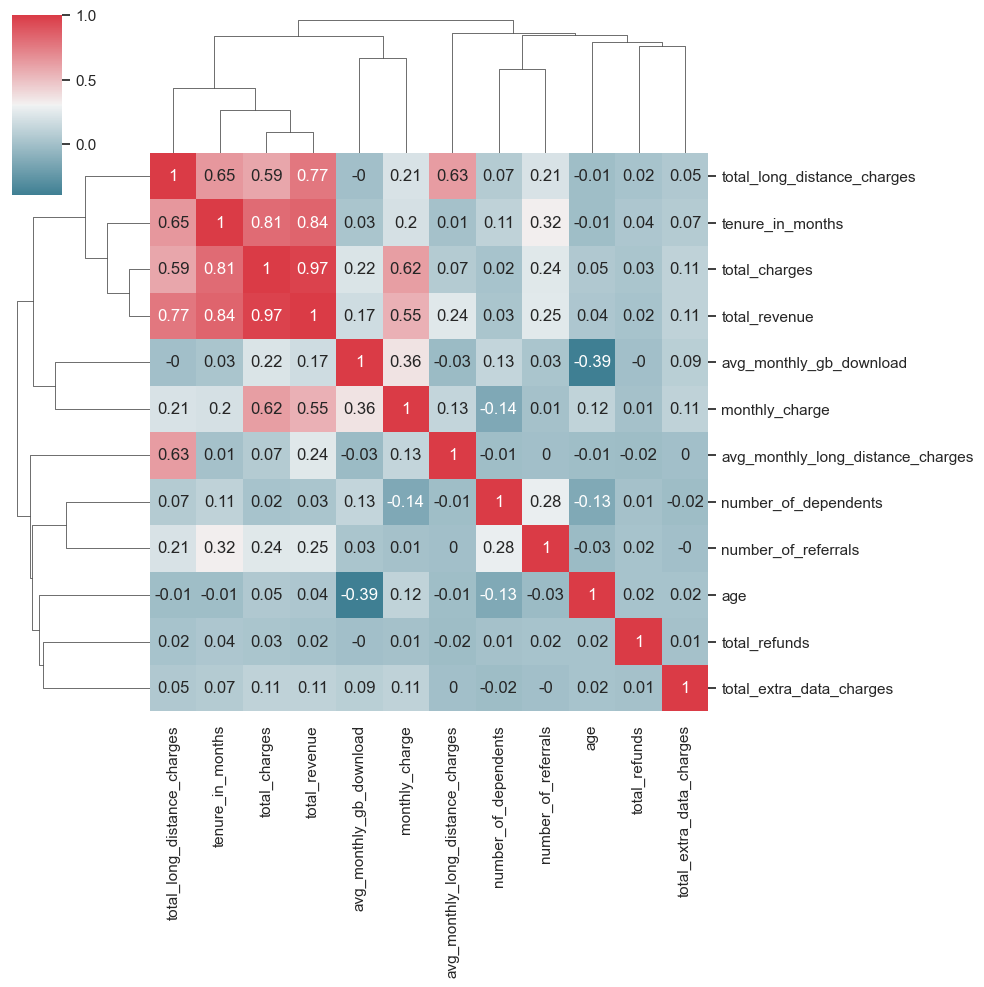

In [50]:
# Gerar matriz de correlação
plt.figure(figsize=(18,8))
sb.clustermap(base_hist_eda.corr().round(2), annot=True, cmap=sb.diverging_palette(220, 10, as_cmap=True))

* Percebe-se que algumas variáveis possuem com correlação altíssima (como total_revenue e total_charges, latitude e zip_code, total_revenue e tenure_in_months), se tornando desnecessário manter as duas.
* Porém mesmo que total_revenue e tenure_in_months sejam correlatas, ainda existem coclusões interessantes entre as duas variáveis. 

#### Relação por Pares (Seaborn Pairplot)

### 🔴 <font color='red'>IMPORTANTE</font>
- Alterar fundo dos gráficos para branco

In [51]:
# Criar amostra de 600 observações para avaliar melhor a relação entre as variáveis
base_hist_eda_sample = base_hist_eda.sample(n=600)

In [52]:
# Excluir variáveis que são correlatas segundo a tabela gerada acima
col_desnec = ['total_charges','total_revenue','total_refunds','total_extra_data_charges',\
             'number_of_referrals','number_of_dependents','avg_monthly_gb_download','total_long_distance_charges']

# tenure_in_months não foi excluída porque existem conclusões interessantes a partir dessa variável
base_hist_eda_sample = base_hist_eda_sample.drop(columns = col_desnec)

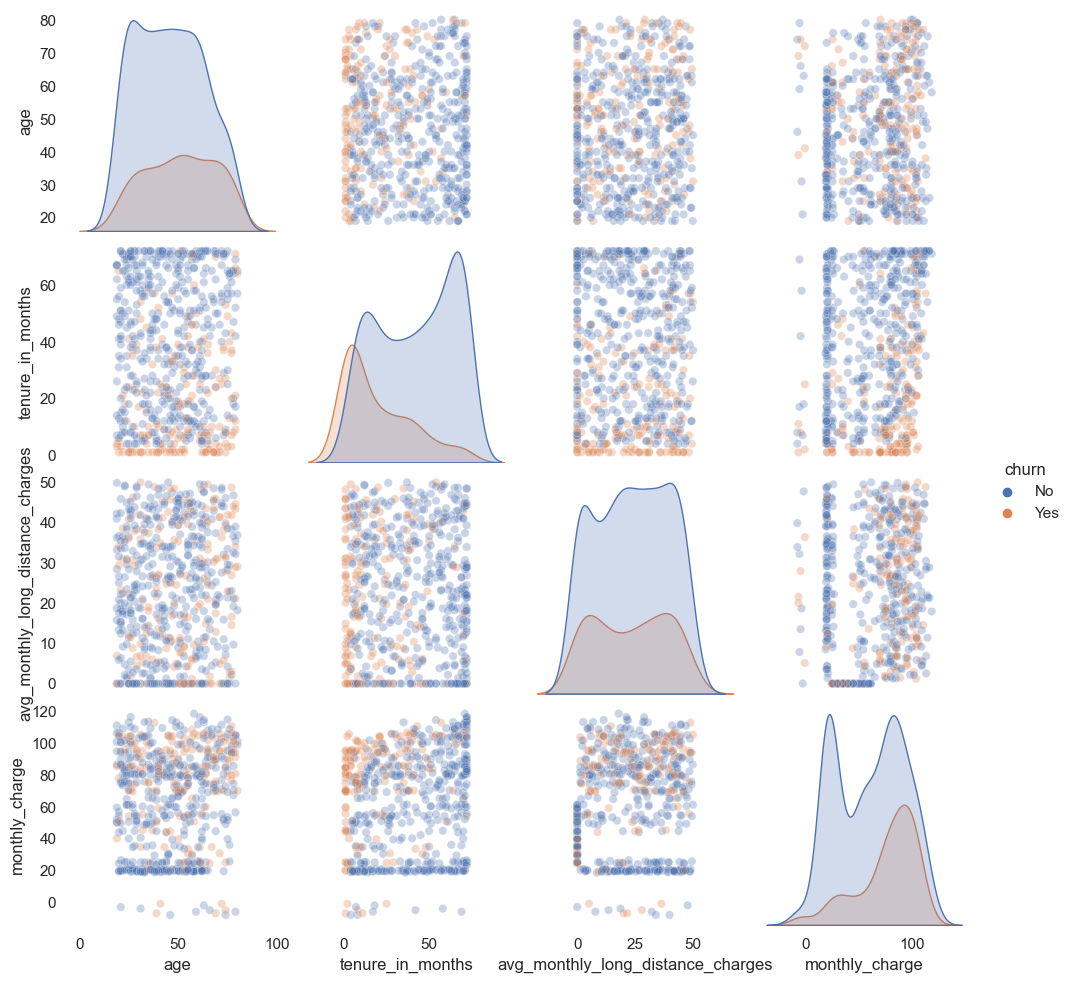

In [53]:
# Personalização dos gráficos
sb.set(style='darkgrid')
sb.set(rc={'figure.figsize':(12,3)})
sb.set(rc={'axes.facecolor':'white'})

# Plotar gráficos
sb.pairplot(base_hist_eda_sample, hue='churn', 
            diag_kind='auto', 
            plot_kws={'alpha': 0.3})

Principais descobertas:
<ol>
    <li>Tempo de Casa (Meses):
        <ul>
            <li>Existe forte correlação entre a variável de receita e tempo de casa, quanto maior o tempo de casa, maior tende a ser a receita
        </ul></li></br>
    <li>Tarifa Média de Longas Distâncias:
        <ul>
            <li>Existe uma pequena correlação entre essa variável e a receita total do cliente, em que quanto maior a tarifa média de longas distâncias, maior a receita
        </ul></li></br>
    <li>Valor Mensal Cobrado:
        <ul>
            <li>Existe uma pequena correlação entre essa variável e a receita total do cliente, em que quanto maior a tarifa média de longas distâncias, maior a receita
        </ul></li></br>
    <li>Receita Total:
        <ul>
            <li>Como já expresso nos pontos acima, é possível identificar uma forte correlação dessa variável com todas as de valores cobrados, mensalmente ou acumulados.
        </ul></li></br>
    <li>Valor Total Cobrado:
        <ul>
            <li>Alta correlação com a variável de receita, a relação com as outras variáveis também é muito similar
        </ul></li></br>

### 🔴 <font color='red'>IMPORTANTE</font>
- Ajustar a variável de cidade, possui muitos valores distintos e poucos com alguma representatividade

#### Base Geral do Modelo

In [54]:
# Tratar variável de cidade, conforme avaliado na Análise Exploratória
base_hist['city'] = base_hist['city'].apply(
                                lambda x:'San Diego' if x == 'San Diego' else 'Other')

In [55]:
# Excluir variáveis que não fazem sentido para o modelo
col_exc = ['customer_id','zip_code','latitude','longitude','total_refunds','customer_status','churn_category', 
           'churn_reason']
base_hist = base_hist.drop(columns = col_exc)

## Pré-Processamento de Dados <a class="anchor" id="titulo_4"></a>

### 🔴 <font color='red'>IMPORTANTE</font>
- Transformar variáveis categóricas com poucos valores únicos com One Hot Encoder

### Transformação de Variáveis Categóricas <a class="anchor" id="subtitulo_4.1"></a>

In [56]:
# Usar One Hot Encoder variáveis categóricas com poucos valores únicos
categorical_cols = ['offer','internet_type','contract','payment_method','city'] 

base_hist = pd.get_dummies(base_hist, columns = categorical_cols, drop_first=True)
# base_hist.head(10)

In [57]:
# Usar Label Encoder quando forem 2 valores únicos
le = LabelEncoder()
qtd = 0
for col in base_hist.columns[0:]:
    if base_hist[col].dtype == 'object':
        if len(list(base_hist[col].unique())) <= 2:
            le.fit(base_hist[col])
            base_hist[col] = le.transform(base_hist[col])
            qtd += 1
print('Colunas binárias tratadas com label encoder: {}'.format(qtd))

# Usar Label Encoder quando forem 2 valores únicos
le = LabelEncoder()
qtd = 0
for col in base_hist.columns[0:]:
    if base_hist[col].dtype == 'object':
        if len(list(base_hist[col].unique())) >= 3:
            le.fit(base_hist[col])
            base_hist[col] = le.transform(base_hist[col])
            qtd += 1
print('Colunas com mais de 2 valores únicos tratadas com label encodes: {}'.format(qtd))

Colunas binárias tratadas com label encoder: 14
Colunas com mais de 2 valores únicos tratadas com label encodes: 0


### Normalização dos Dados <a class="anchor" id="subtitulo_4.2"></a>

In [58]:
# Resumo da base
base_hist.describe().T.sort_values(ascending = 0,by = "mean").style.background_gradient(cmap = "BuGn")\
.bar(subset = ["std"], color ="red").bar(subset = ["mean"], color ="blue")

,count,mean,std,min,25%,50%,75%,max
total_revenue,6589.000000,3235.218082,2854.600036,21.610000,835.450000,2376.450000,5106.640000,11979.340000
total_charges,6589.000000,2432.042243,2265.500080,18.850000,544.550000,1563.900000,4003.000000,8684.800000
total_long_distance_charges,6589.000000,798.087251,853.767972,0.000000,106.680000,472.680000,1275.120000,3564.720000
monthly_charge,6589.000000,65.030695,31.100727,-10.000000,35.800000,71.050000,90.400000,118.750000
age,6589.000000,46.760510,16.841362,19.000000,33.000000,46.000000,60.000000,80.000000
tenure_in_months,6589.000000,34.499772,23.968734,1.000000,12.000000,32.000000,57.000000,72.000000
avg_monthly_long_distance_charges,6589.000000,23.004277,15.466844,0.000000,9.250000,22.920000,36.440000,49.990000
avg_monthly_gb_download,6589.000000,20.876461,20.406247,0.000000,4.000000,17.000000,27.000000,85.000000
total_extra_data_charges,6589.000000,7.169525,25.803163,0.000000,0.000000,0.000000,0.000000,150.000000
number_of_referrals,6589.000000,2.020944,3.024016,0.000000,0.000000,0.000000,3.000000,11.000000


In [59]:
# Normalizar variáveis
col_norm = ['total_revenue','total_charges','total_long_distance_charges','monthly_charge','age',
            'tenure_in_months','avg_monthly_long_distance_charges','avg_monthly_gb_download','total_extra_data_charges',
            'number_of_referrals']
base_hist[col_norm] = StandardScaler().fit_transform(base_hist[col_norm])

base_hist.head()

,gender,age,married,number_of_dependents,number_of_referrals,tenure_in_months,phone_service,avg_monthly_long_distance_charges,multiple_lines,internet_service,...,offer_Offer D,offer_Offer E,internet_type_DSL,internet_type_Fiber Optic,internet_type_None,contract_One Year,contract_Two Year,payment_method_Credit Card,payment_method_Mailed Check,city_San Diego
0,0,-0.579600,1,0,-0.006926,-1.063957,1,1.253468,0,1,...,0,0,0,0,0,1,0,1,0,0
1,1,-0.045161,0,0,-0.668349,-1.063957,1,-0.796233,1,1,...,0,0,0,0,0,0,0,1,0,0
2,1,0.192368,0,0,-0.668349,-1.272578,1,0.688345,0,1,...,0,1,0,1,0,0,0,0,0,0
3,1,1.855067,1,0,-0.337638,-0.897060,1,0.311381,0,1,...,1,0,0,1,0,0,0,0,0,0
4,0,1.676921,1,0,0.323785,-1.314302,1,-1.010255,0,1,...,0,0,0,1,0,0,0,1,0,0


### Separação das Bases de Treino e Teste <a class="anchor" id="subtitulo_4.3"></a>

In [60]:
# Separação da Variável Target
X = base_hist.drop(columns = ['churn'])
y = base_hist['churn'].values

In [61]:
# Separar em 70% para treino e 30% para teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 4, stratify =y)

### Balanceamento da Base de Treino <a class="anchor" id="subtitulo_4.4"></a>

<AxesSubplot:ylabel='churn'>

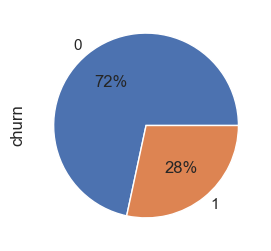

In [62]:
# Distribuição Atual
base_hist['churn'].value_counts().plot(kind='pie', y='perc', autopct='%1.0f%%', figsize = (3, 3))

### 🔴 <font color='red'>IMPORTANTE</font>
- Comparar o uso do SMOTENC, para um dataset com mix de variáveis categóricas e numéricas
- No caso de seguir com o SMOTEENN(), excluir o segundo tratamento, não é necessário equilíbrio entre as classes

In [63]:
#pd.DataFrame(X_train.dtypes).reset_index().reset_index()

<AxesSubplot:ylabel='0'>

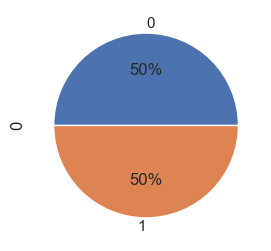

In [64]:
# Variáveis categóricas
variaveis_categoricas = ['gender','married','phone_service','multiple_lines','internet_service','online_security',
                         'online_backup','device_protection_plan','premium_tech_support','streaming_tv','streaming_movies',
                         'streaming_music','unlimited_data','paperless_billing','offer_Offer A','offer_Offer B',
                         'offer_Offer C','offer_Offer D','offer_Offer E','internet_type_DSL','internet_type_Fiber Optic',
                         'internet_type_None','contract_One Year','contract_Two Year','payment_method_Credit Card',
                         'payment_method_Mailed Check','city_San Diego']
variaveis_base = pd.DataFrame(X_train.dtypes).reset_index()
variaveis_base2 = variaveis_base[variaveis_base['index'].isin(variaveis_categoricas)]

# Balancear dados de treino
smc = SMOTENC(random_state=42, categorical_features=variaveis_base2.index)
X_train, y_train = smc.fit_resample(X_train, y_train)
# X_train, y_train = SMOTEENN().fit_resample(X_train, y_train)

# Nova Distribuição
grafico = pd.DataFrame(y_train)
grafico[0].value_counts().plot(kind='pie', y='perc', autopct='%1.0f%%', figsize = (3, 3))

## Criação dos Modelos de ML <a class="anchor" id="titulo_5"></a>

### 🔴 <font color='red'>IMPORTANTE</font>

##### Random Forest
- Substituir os hiperparâmetros de profundidade e min_samples_leaf pelo ccp_alpha

##### XGBoost
- Pesquisar árvores com baixa profundidade (1 e 2)
- Restringir mais a profundidade e pesquisar o n_estimators
- Pesquisar valores de parâmetros de regularização
- Implementar o early stopping (eval-metric e early-stopping-rounds)
- Faz sentido usar a mesma métrica que a usada no grid search CV

Tunagem do hiperparâmetro Gamma no XGBoost \
https://medium.com/data-design/xgboost-hi-im-gamma-what-can-i-do-for-you-and-the-tuning-of-regularization-a42ea17e6ab6

Gamma = controle de complexidade

#### Avaliação dos melhores hiperparâmetros

In [66]:
pipe = Pipeline([("classifier", DecisionTreeClassifier())])
search_space = [{"classifier": [DecisionTreeClassifier()],
                                   'classifier__criterion': ['gini', 'entropy'],
                                   'classifier__ccp_alpha':[0, .05, .01, .001, .0001]
                    },
                    {"classifier": [RandomForestClassifier()],
                                   'classifier__ccp_alpha': [0, .05, .01, .001, .0001],
                                   'classifier__n_estimators': [10, 25, 50, 75, 100, 400, 500, 600, 1000, 1250, 1500, 2000]
                    },
                    {"classifier": [XGBClassifier()],
                                   'classifier__max_depth': [1, 2],
                                   'classifier__eta': [.3, .2, .1, .05, .01, .001],
                                   'classifier__gamma': [0, 1, 2, 5, 10, 15],
                                   'classifier__colsample_bytree': [0, .5, .8, .9]
                    }]
grid_search = GridSearchCV(pipe, search_space, scoring='f1_micro', cv=5, verbose=1,n_jobs=- 1)
# scoring: 'accuracy', 'roc_auc', 'f1_micro'
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 358 candidates, totalling 1790 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid=[{'classifier': [DecisionTreeClassifier()],
                          'classifier__ccp_alpha': [0, 0.05, 0.01, 0.001,
                                                    0.0001],
                          'classifier__criterion': ['gini', 'entropy']},
                         {'classifier': [RandomForestClassifier(ccp_alpha=0,
                                                                n_estimators=1000)],
                          'classifier__ccp_alpha': [0, 0.05, 0.01...
                                                       max_leaves=None,
                                                       min_child_weight=None,
                                                       missing=nan,
                                                       monotone_constraints=None,
                                                       n_estimators=100,
                                                       n_jobs=None,
                                                       num_parallel_tree=None,
                                                       predictor=None,
                                                       random_state=None, ...)],
                          'classifier__colsample_bytree': [0, 0.5, 0.8, 0.9],
                          'classifier__eta': [0.3, 0.2, 0.1, 0.05, 0.01, 0.001],
                          'classifier__gamma': [0, 1, 2, 5, 10, 15],
                          'classifier__max_depth': [1, 2]}],
             scoring='f1_micro', verbose=1)

In [67]:
# print(grid_search.best_estimator_.get_params()["classifier"])
# pd.DataFrame(grid_search.cv_results_)

Tempo de execução: https://datascience.stackexchange.com/questions/29495/how-to-estimate-gridsearchcv-computing-time

In [68]:
mean_gs = grid_search.cv_results_['mean_test_score']
std_gs = grid_search.cv_results_['std_test_score']
mean_fit_time_gs = grid_search.cv_results_['mean_fit_time']
mean_score_time_gs = grid_search.cv_results_['mean_score_time']
std_fit_time_gs = grid_search.cv_results_['std_fit_time']
std_score_time_gs = grid_search.cv_results_['std_score_time']
n_splits  = grid_search.n_splits_


# Criar tabela com resultados
tab_hiperparametros_col = ['classifier','criterion', 'ccp_alpha', 'n_estimators', 'max_depth', 'eta', 'gamma', 'colsample_bytree', 'mean_test_score', 'std_test_score', 'time_run']
tab_hiperparametros = pd.DataFrame(columns = tab_hiperparametros_col)

i = 0
for mean, std, m_fit_time, m_score_time, s_fit_time, s_score_time, params in zip(mean_gs, std_gs, mean_fit_time_gs, mean_score_time_gs, std_fit_time_gs, std_score_time_gs, enumerate(grid_search.cv_results_['params'])):
    
    try: classifier = params[1]['classifier']
    except: classifier = '-'
    try: criterion = params[1]['classifier__criterion']
    except: criterion = '-'
    try: ccp_alpha = params[1]['classifier__ccp_alpha']
    except: ccp_alpha = '-'
    try: n_estimators = params[1]['classifier__n_estimators']
    except: n_estimators = '-'
    try: max_depth = params[1]['classifier__max_depth']
    except: max_depth = '-'
    try: eta = params[1]['classifier__eta']
    except: eta = '-'
    try: gamma = params[1]['classifier__gamma']
    except: gamma = '-'
    try: colsample_bytree = params[1]['classifier__colsample_bytree']
    except: colsample_bytree = '-'
    try: time = (m_fit_time + m_score_time + s_fit_time + s_score_time) * n_splits
    except: time = '-'
        
        
    tab_hiperparametros.loc[i] = [classifier,
                                    criterion,
                                    ccp_alpha,
                                    n_estimators,
                                    max_depth,
                                    eta,
                                    gamma,
                                    colsample_bytree,
                                    round(mean,5),
                                    round(std,5),
                                    round(time,2)]
    i+=1

# Ordenar pelos maiores scores
tab_hiperparametros['classifier'] = tab_hiperparametros['classifier'].astype(str).str.split('Classifier').str[0]
tab_hiperparametros = tab_hiperparametros.sort_values(by = ['mean_test_score','std_test_score'], ascending = [False,True])#.head(15)
tab_hiperparametros.to_clipboard()
tab_hiperparametros.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])]).\
                                                    set_properties(**{'text-align': 'center'}).\
                                                    hide_index()

classifier,criterion,ccp_alpha,n_estimators,max_depth,eta,gamma,colsample_bytree,mean_test_score,std_test_score,time_run
RandomForest,-,0.000000,1000,-,-,-,-,0.896500,0.048540,54.640000
RandomForest,-,0.000100,75,-,-,-,-,0.896500,0.049090,4.260000
RandomForest,-,0.000000,600,-,-,-,-,0.896500,0.049410,30.980000
RandomForest,-,0.000100,600,-,-,-,-,0.895900,0.050550,33.700000
RandomForest,-,0.000100,1500,-,-,-,-,0.895750,0.050750,101.250000
RandomForest,-,0.000100,400,-,-,-,-,0.895590,0.050440,22.470000
RandomForest,-,0.000100,1000,-,-,-,-,0.895290,0.049830,56.460000
RandomForest,-,0.000100,2000,-,-,-,-,0.895290,0.050220,176.030000
RandomForest,-,0.000100,500,-,-,-,-,0.895140,0.048150,28.060000
RandomForest,-,0.000000,500,-,-,-,-,0.895140,0.049220,25.650000


In [69]:
tab_hiperparametros = tab_hiperparametros.sort_values(by='mean_test_score',ascending=False,)
tab_melhores_hiperparametros = tab_hiperparametros.drop_duplicates(subset=['classifier'])

print('\nMelhores Hiperparâmetros por Modelo:')
tab_melhores_hiperparametros.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])]).\
                                                    set_properties(**{'text-align': 'center'}).\
                                                    hide_index()


Melhores Hiperparâmetros por Modelo:


classifier,criterion,ccp_alpha,n_estimators,max_depth,eta,gamma,colsample_bytree,mean_test_score,std_test_score,time_run
RandomForest,-,0.000000,1000,-,-,-,-,0.896500,0.048540,54.640000
XGB,-,-,-,2,0.200000,1,0.500000,0.887570,0.033220,4.070000
DecisionTree,entropy,0.001000,-,-,-,-,-,0.861390,0.048900,0.520000


In [70]:
# Personalização dos gráficos
sb.set(style='darkgrid')
sb.set(rc={'figure.figsize':(12,3)})
sb.set(rc={'axes.facecolor':'white', 'grid.color': '.91'})

# Criar funções para gerar os gráficos de comparação entre os modelos
def comparar_acuracia_e_desvio(modelo, parametro):
    df = tab_hiperparametros[tab_hiperparametros['classifier'] == modelo]
    df_pivot = np.round(pd.pivot_table(df, values=['mean_test_score','std_test_score'], index=parametro, aggfunc=np.mean),4)
    df_pivot = df_pivot.reset_index()
    # sb.pointplot(data=base, x="eta", y="mean_test_score", errorbar="std_test_score", err_style='bars')
    fig, (img) = plt.subplots(sharex=True)
    img.errorbar(x = df_pivot[parametro],
                 y = df_pivot['mean_test_score'],
                 yerr=df_pivot['std_test_score'],fmt='-o')
    img.set_title(modelo, fontweight='bold')
    img.legend('mean_test_score', 'mean_test_score', numpoints=1)
    plt.ylim([0.75, 1])
    plt.xlabel(parametro)
    plt.ylabel('mean_test_score')
    return img

def comparar_acuracia_e_desvio_2(modelo, parametro1, parametro2):
    df = tab_hiperparametros[tab_hiperparametros['classifier'] == modelo]
    df_pivot = np.round(pd.pivot_table(df, values=['mean_test_score','std_test_score'], index=[parametro1,parametro2], aggfunc=np.mean),4)
    df_pivot = df_pivot.reset_index()
    lvls = df_pivot[parametro2].unique()
    fig,(img) = plt.subplots(sharex=True)
    for i in lvls:
        img.errorbar(x = df_pivot[df_pivot[parametro2]==i][parametro1],
                     y = df_pivot[df_pivot[parametro2]==i]['mean_test_score'],
                     yerr = df_pivot[df_pivot[parametro2]==i]['std_test_score'],
                     label=i,fmt='o-')
    img.set_title(modelo+' vs '+parametro2, fontweight='bold')
    img.legend()
    plt.ylim([0.65, 1])
    plt.xlabel(parametro1)
    plt.ylabel('mean_test_score')
    return img

### 🔴 <font color='red'>IMPORTANTE</font>
- Gráficos serão utilizados para identificar quais hiperparêmetros ainda geram mudanças substanciais de f1 perto do ótimo

<AxesSubplot:title={'center':'DecisionTree vs criterion'}, xlabel='ccp_alpha', ylabel='mean_test_score'>

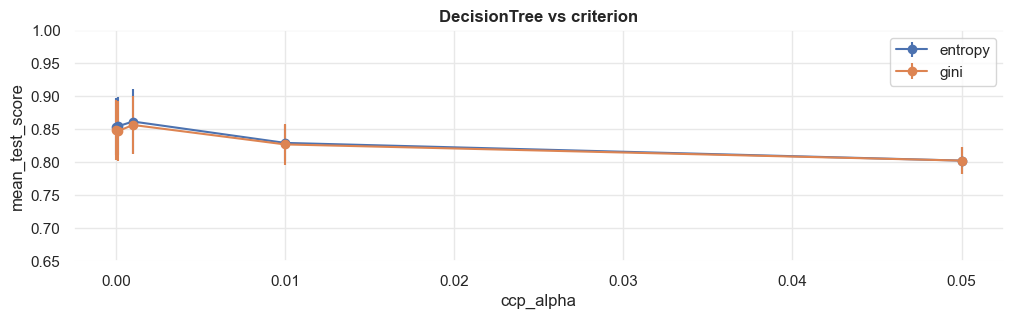

In [71]:
# Decision Tree
comparar_acuracia_e_desvio_2('DecisionTree','ccp_alpha','criterion')

<AxesSubplot:title={'center':'RandomForest vs ccp_alpha'}, xlabel='n_estimators', ylabel='mean_test_score'>

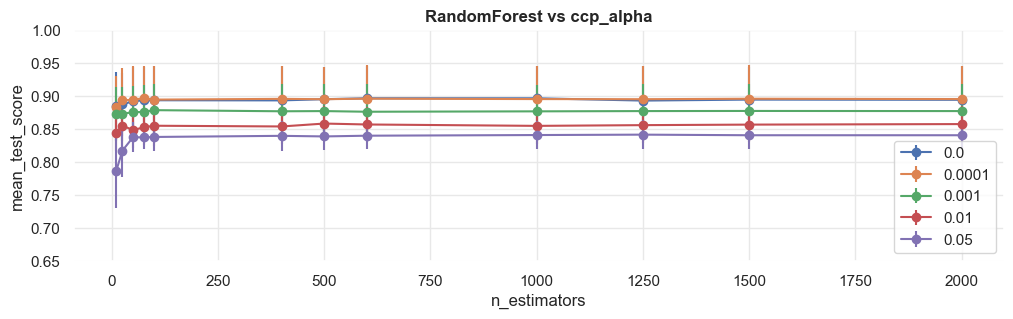

In [72]:
# Random Forest
comparar_acuracia_e_desvio_2('RandomForest','n_estimators','ccp_alpha')

<AxesSubplot:title={'center':'RandomForest vs n_estimators'}, xlabel='ccp_alpha', ylabel='mean_test_score'>

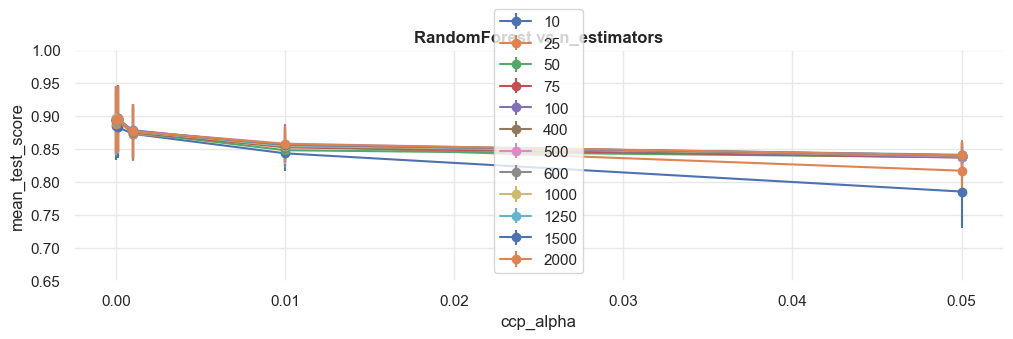

In [73]:
# Random Forest
comparar_acuracia_e_desvio_2('RandomForest','ccp_alpha','n_estimators')

<AxesSubplot:title={'center':'XGB vs max_depth'}, xlabel='eta', ylabel='mean_test_score'>

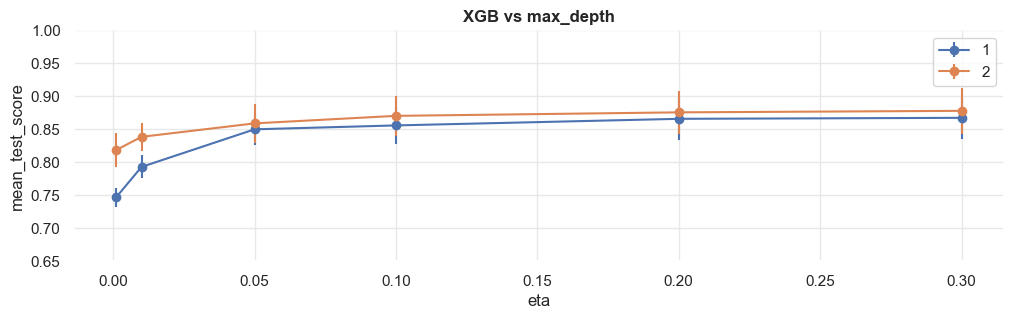

In [74]:
# XGBoost
comparar_acuracia_e_desvio_2('XGB','eta','max_depth')

<AxesSubplot:title={'center':'XGB vs max_depth'}, xlabel='colsample_bytree', ylabel='mean_test_score'>

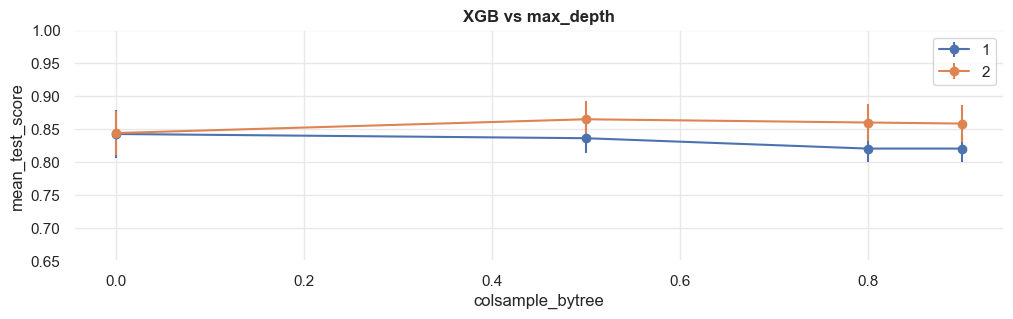

In [75]:
# XGBoost
comparar_acuracia_e_desvio_2('XGB','colsample_bytree','max_depth')

<AxesSubplot:title={'center':'XGB vs max_depth'}, xlabel='gamma', ylabel='mean_test_score'>

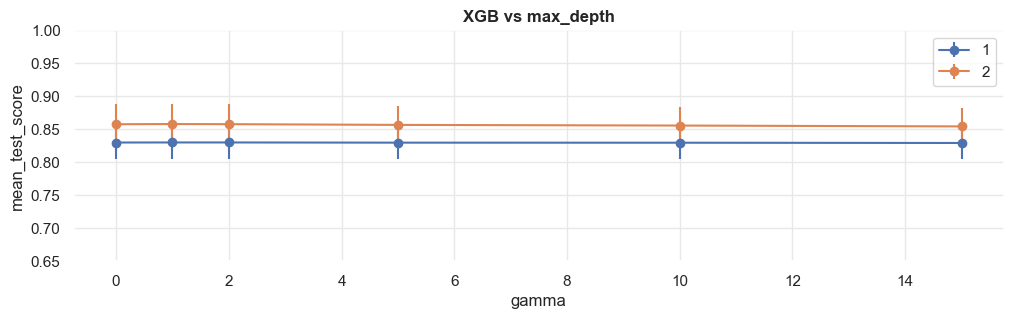

In [76]:
# XGBoost
comparar_acuracia_e_desvio_2('XGB','gamma','max_depth')

### Melhores Hiperparâmetros da 1ª Rodada do GridSearchCV

##### Árvore de Decisão (86,1%)
- criterion = 'entropy'
- ccp_alpha = 0.001

##### Random Forest (89,6%)
- ccp_alpha = 0.0001
- n_estimators = 75

##### XGBoost (88,7%)
- max_depth = 2
- eta = 0.2 (quando os resultados estabilizam)
- gamma = reavaliar impacto
- colsample_bytree = 0.5

#### 2ª Rodada de GridSearchCV para o XGBoost - hiperparâmetro gamma vs profundidade

In [77]:
pipe_xgb_2 = Pipeline([("classifier", XGBClassifier())])
search_space_xgb_2 = [{"classifier": [XGBClassifier()],
                                   'classifier__max_depth': [2,5,10],
                                   'classifier__eta': [.2],
                                   'classifier__gamma': [.001,.01,.1,.5,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
                                   'classifier__colsample_bytree': [.5]
                    }]
grid_search_xgb_2 = GridSearchCV(pipe_xgb_2, search_space_xgb_2, scoring='f1_micro', cv=5, verbose=1,n_jobs=- 1)
grid_search_xgb_2.fit(X_train, y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None, gpu_id=None,
                                                      grow_policy=None,
                                                      importance_type=None,
                                                      interaction_constr...
                                                       min_child_weight=None,
                                                       missing=nan,
                                                       monotone_constraints=None,
                                                       n_estimators=100,
                                                       n_jobs=None,
                                                       num_parallel_tree=None,
                                                       predictor=None, ...)],
                          'classifier__colsample_bytree': [0.5],
                          'classifier__eta': [0.2],
                          'classifier__gamma': [0.001, 0.01, 0.1, 0.5, 0, 1, 2,
                                                3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                                13, 14, 15, 16, 17, 18, 19,
                                                20],
                          'classifier__max_depth': [2, 5, 10]}],
             scoring='f1_micro', verbose=1)

In [78]:
mean_gs = grid_search_xgb_2.cv_results_['mean_test_score']
std_gs = grid_search_xgb_2.cv_results_['std_test_score']
mean_fit_time_gs = grid_search_xgb_2.cv_results_['mean_fit_time']
mean_score_time_gs = grid_search_xgb_2.cv_results_['mean_score_time']
std_fit_time_gs = grid_search_xgb_2.cv_results_['std_fit_time']
std_score_time_gs = grid_search_xgb_2.cv_results_['std_score_time']
n_splits  = grid_search_xgb_2.n_splits_


# Criar tabela com resultados
tab_hiperparametros_col = ['classifier','max_depth', 'eta', 'gamma', 'colsample_bytree', 'mean_test_score', 'std_test_score', 'time_run']
tab_hiperparametros = pd.DataFrame(columns = tab_hiperparametros_col)

i = 0
for mean, std, m_fit_time, m_score_time, s_fit_time, s_score_time, params in zip(mean_gs, std_gs, mean_fit_time_gs, mean_score_time_gs, std_fit_time_gs, std_score_time_gs, enumerate(grid_search_xgb_2.cv_results_['params'])):
    
    try: classifier = params[1]['classifier']
    except: classifier = '-'
    try: max_depth = params[1]['classifier__max_depth']
    except: max_depth = '-'
    try: eta = params[1]['classifier__eta']
    except: eta = '-'
    try: gamma = params[1]['classifier__gamma']
    except: gamma = '-'
    try: colsample_bytree = params[1]['classifier__colsample_bytree']
    except: colsample_bytree = '-'
    try: time = (m_fit_time + m_score_time + s_fit_time + s_score_time) * n_splits
    except: time = '-'
        
        
    tab_hiperparametros.loc[i] = [classifier,
                                    max_depth,
                                    eta,
                                    gamma,
                                    colsample_bytree,
                                    round(mean,5),
                                    round(std,5),
                                    round(time,2)]
    i+=1

# Ordenar pelos maiores scores
tab_hiperparametros['classifier'] = tab_hiperparametros['classifier'].astype(str).str.split('Classifier').str[0]
tab_hiperparametros = tab_hiperparametros.sort_values(by = ['mean_test_score','std_test_score'], ascending = [False,True])#.head(15)
tab_hiperparametros.to_clipboard()
tab_hiperparametros.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])]).\
                                                    set_properties(**{'text-align': 'center'}).\
                                                    hide_index()

classifier,max_depth,eta,gamma,colsample_bytree,mean_test_score,std_test_score,time_run
XGB,10,0.200000,0.000000,0.500000,0.903760,0.047060,12.270000
XGB,10,0.200000,0.500000,0.500000,0.902250,0.048320,13.140000
XGB,10,0.200000,0.100000,0.500000,0.901340,0.049290,14.830000
XGB,10,0.200000,0.010000,0.500000,0.901190,0.048980,13.900000
XGB,10,0.200000,1.000000,0.500000,0.899680,0.047710,11.130000
XGB,10,0.200000,0.001000,0.500000,0.899680,0.048200,14.000000
XGB,5,0.200000,0.100000,0.500000,0.896350,0.045070,7.400000
XGB,5,0.200000,0.500000,0.500000,0.896200,0.044810,7.320000
XGB,10,0.200000,3.000000,0.500000,0.896050,0.049730,12.800000
XGB,10,0.200000,2.000000,0.500000,0.895740,0.047730,10.750000


In [79]:
# Personalização dos gráficos
sb.set(style='darkgrid')
sb.set(rc={'figure.figsize':(12,3)})
sb.set(rc={'axes.facecolor':'white', 'grid.color': '.91'})

def comparar_acuracia_e_desvio_2(modelo, parametro1, parametro2):
    df = tab_hiperparametros[tab_hiperparametros['classifier'] == modelo]
    df_pivot = np.round(pd.pivot_table(df, values=['mean_test_score','std_test_score'], index=[parametro1,parametro2], aggfunc=np.mean),4)
    df_pivot = df_pivot.reset_index()
    lvls = df_pivot[parametro2].unique()
    fig,(img) = plt.subplots(sharex=True)
    for i in lvls:
        img.errorbar(x = df_pivot[df_pivot[parametro2]==i][parametro1],
                     y = df_pivot[df_pivot[parametro2]==i]['mean_test_score'],
                     yerr = df_pivot[df_pivot[parametro2]==i]['std_test_score'],
                     label=i,fmt='o-')
    img.set_title(modelo+' vs '+parametro2, fontweight='bold')
    img.legend()
    plt.ylim([0.80, 1])
    plt.xlabel(parametro1)
    plt.ylabel('mean_test_score')
    return img

<AxesSubplot:title={'center':'XGB vs max_depth'}, xlabel='gamma', ylabel='mean_test_score'>

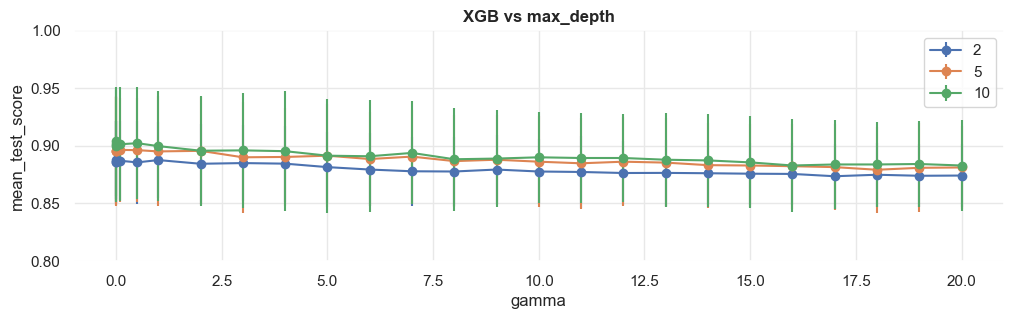

In [80]:
# XGBoost gamma baixo
comparar_acuracia_e_desvio_2('XGB','gamma','max_depth')

Gamma mais baixo funciona melhor para o conjunto de dados

### Melhores Hiperparâmetros da 2ª Rodada do GridSearchCV - hiperparâmetro gamma vs profundidade

##### Árvore de Decisão (86,1%)
- criterion = 'entropy'
- ccp_alpha = 0.001

##### Random Forest (89,6%)
- ccp_alpha = 0.0001
- n_estimators = 75

##### XGBoost (89,6%)
- max_depth = 5
- eta = 0.2
- gamma = 0.1
- colsample_bytree = 0.5

#### 3ª Rodada de GridSearchCV - valores próximos aos melhores escolhidos

In [108]:
pipe_3 = Pipeline([("classifier", DecisionTreeClassifier())])
search_space_3 = [{"classifier": [DecisionTreeClassifier()],
                                   'classifier__criterion': ['entropy'],
                                   'classifier__ccp_alpha':[.0001,.0005,.001,.005,.01]
                    },
                    {"classifier": [RandomForestClassifier()],
                                   'classifier__ccp_alpha': [.0001,.0005,.001,.005,.01],
                                   'classifier__n_estimators': [55,65,75,85,95]
                    },
                    {"classifier": [XGBClassifier()],
                                   'classifier__max_depth': [2,5,10],
                                   'classifier__eta': [0.05,.1,.2,.3],
                                   'classifier__gamma': [.001,.01,.1,.5,0,1,2],
                                   'classifier__colsample_bytree': [.3,.5,.6,.7]
                    }]
grid_search_3 = GridSearchCV(pipe_3, search_space_3, scoring='f1_micro', cv=5, verbose=1,n_jobs=- 1)
# scoring: 'accuracy', 'roc_auc', 'f1_micro'
grid_search_3.fit(X_train, y_train)

Fitting 5 folds for each of 366 candidates, totalling 1830 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid=[{'classifier': [DecisionTreeClassifier()],
                          'classifier__ccp_alpha': [0.0001, 0.0005, 0.001,
                                                    0.005, 0.01],
                          'classifier__criterion': ['entropy']},
                         {'classifier': [RandomForestClassifier()],
                          'classifier__ccp_alpha': [0.0001, 0.0005, 0.001,
                                                    0.005, 0.01],
                          'classifi...
                                                       max_depth=10,
                                                       max_leaves=None,
                                                       min_child_weight=None,
                                                       missing=nan,
                                                       monotone_constraints=None,
                                                       n_estimators=100,
                                                       n_jobs=None,
                                                       num_parallel_tree=None,
                                                       predictor=None, ...)],
                          'classifier__colsample_bytree': [0.3, 0.5, 0.6, 0.7],
                          'classifier__eta': [0.05, 0.1, 0.2, 0.3],
                          'classifier__gamma': [0.001, 0.01, 0.1, 0.5, 0, 1, 2],
                          'classifier__max_depth': [2, 5, 10]}],
             scoring='f1_micro', verbose=1)

In [109]:
mean_gs = grid_search_3.cv_results_['mean_test_score']
std_gs = grid_search_3.cv_results_['std_test_score']
mean_fit_time_gs = grid_search_3.cv_results_['mean_fit_time']
mean_score_time_gs = grid_search_3.cv_results_['mean_score_time']
std_fit_time_gs = grid_search_3.cv_results_['std_fit_time']
std_score_time_gs = grid_search_3.cv_results_['std_score_time']
n_splits  = grid_search_3.n_splits_


# Criar tabela com resultados
tab_hiperparametros_col = ['classifier','criterion', 'ccp_alpha', 'n_estimators', 'max_depth', 'eta', 'gamma', 'colsample_bytree', 'mean_test_score', 'std_test_score', 'time_run']
tab_hiperparametros = pd.DataFrame(columns = tab_hiperparametros_col)

i = 0
for mean, std, m_fit_time, m_score_time, s_fit_time, s_score_time, params in zip(mean_gs, std_gs, mean_fit_time_gs, mean_score_time_gs, std_fit_time_gs, std_score_time_gs, enumerate(grid_search_3.cv_results_['params'])):
    
    try: classifier = params[1]['classifier']
    except: classifier = '-'
    try: criterion = params[1]['classifier__criterion']
    except: criterion = '-'
    try: ccp_alpha = params[1]['classifier__ccp_alpha']
    except: ccp_alpha = '-'
    try: n_estimators = params[1]['classifier__n_estimators']
    except: n_estimators = '-'
    try: max_depth = params[1]['classifier__max_depth']
    except: max_depth = '-'
    try: eta = params[1]['classifier__eta']
    except: eta = '-'
    try: gamma = params[1]['classifier__gamma']
    except: gamma = '-'
    try: colsample_bytree = params[1]['classifier__colsample_bytree']
    except: colsample_bytree = '-'
    try: time = (m_fit_time + m_score_time + s_fit_time + s_score_time) * n_splits
    except: time = '-'
        
        
    tab_hiperparametros.loc[i] = [classifier,
                                    criterion,
                                    ccp_alpha,
                                    n_estimators,
                                    max_depth,
                                    eta,
                                    gamma,
                                    colsample_bytree,
                                    round(mean,5),
                                    round(std,5),
                                    round(time,2)]
    i+=1

# Ordenar pelos maiores scores
tab_hiperparametros['classifier'] = tab_hiperparametros['classifier'].astype(str).str.split('Classifier').str[0]
tab_hiperparametros = tab_hiperparametros.sort_values(by = ['mean_test_score','std_test_score'], ascending = [False,True])#.head(15)
tab_hiperparametros.to_clipboard()
tab_hiperparametros.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])]).\
                                                    set_properties(**{'text-align': 'center'}).\
                                                    hide_index()

classifier,criterion,ccp_alpha,n_estimators,max_depth,eta,gamma,colsample_bytree,mean_test_score,std_test_score,time_run
XGB,-,-,-,10,0.200000,0,0.500000,0.903760,0.047060,16.680000
XGB,-,-,-,10,0.300000,0,0.500000,0.902860,0.047340,10.010000
XGB,-,-,-,10,0.300000,0,0.600000,0.902400,0.048690,14.560000
XGB,-,-,-,10,0.200000,0.500000,0.500000,0.902250,0.048320,14.920000
XGB,-,-,-,10,0.100000,0.500000,0.500000,0.902100,0.049070,10.210000
XGB,-,-,-,10,0.200000,0.100000,0.600000,0.901950,0.048840,15.280000
XGB,-,-,-,10,0.300000,0.001000,0.500000,0.901950,0.051550,10.220000
XGB,-,-,-,10,0.200000,0.010000,0.700000,0.901800,0.046920,21.460000
XGB,-,-,-,10,0.200000,0,0.600000,0.901800,0.048450,13.760000
XGB,-,-,-,10,0.100000,0,0.500000,0.901650,0.047060,10.050000


In [110]:
tab_hiperparametros = tab_hiperparametros.sort_values(by='mean_test_score',ascending=False,)
tab_melhores_hiperparametros = tab_hiperparametros.drop_duplicates(subset=['classifier'])

print('\nMelhores Hiperparâmetros por Modelo:')
tab_melhores_hiperparametros.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])]).\
                                                    set_properties(**{'text-align': 'center'}).\
                                                    hide_index()


Melhores Hiperparâmetros por Modelo:


classifier,criterion,ccp_alpha,n_estimators,max_depth,eta,gamma,colsample_bytree,mean_test_score,std_test_score,time_run
XGB,-,-,-,10,0.200000,0,0.500000,0.903760,0.047060,16.680000
RandomForest,-,0.000100,95,-,-,-,-,0.893780,0.051460,4.310000
DecisionTree,entropy,0.001000,-,-,-,-,-,0.861850,0.049140,0.560000


<AxesSubplot:title={'center':'DecisionTree vs criterion'}, xlabel='ccp_alpha', ylabel='mean_test_score'>

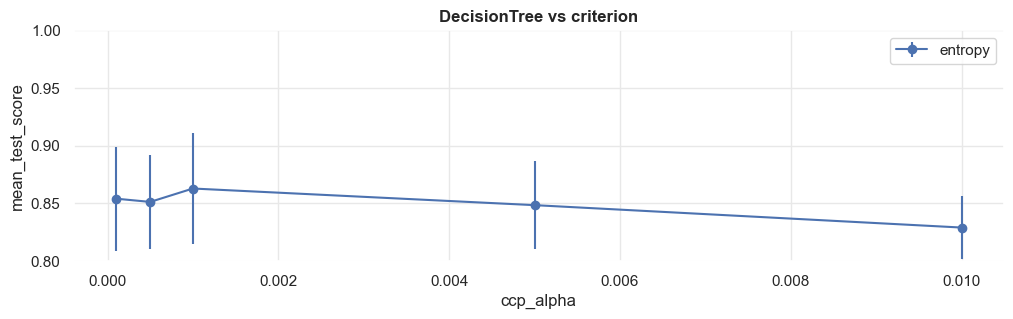

In [101]:
# Decision Tree
comparar_acuracia_e_desvio_2('DecisionTree','ccp_alpha','criterion')

<AxesSubplot:title={'center':'RandomForest vs ccp_alpha'}, xlabel='n_estimators', ylabel='mean_test_score'>

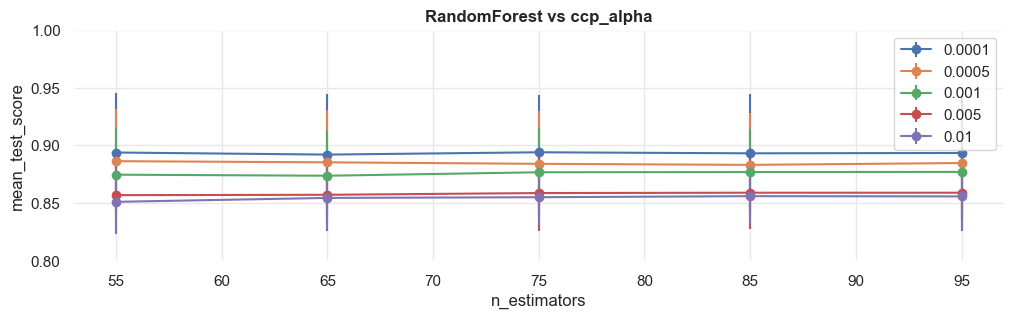

In [102]:
# Random Forest
comparar_acuracia_e_desvio_2('RandomForest','n_estimators','ccp_alpha')

<AxesSubplot:title={'center':'RandomForest vs n_estimators'}, xlabel='ccp_alpha', ylabel='mean_test_score'>

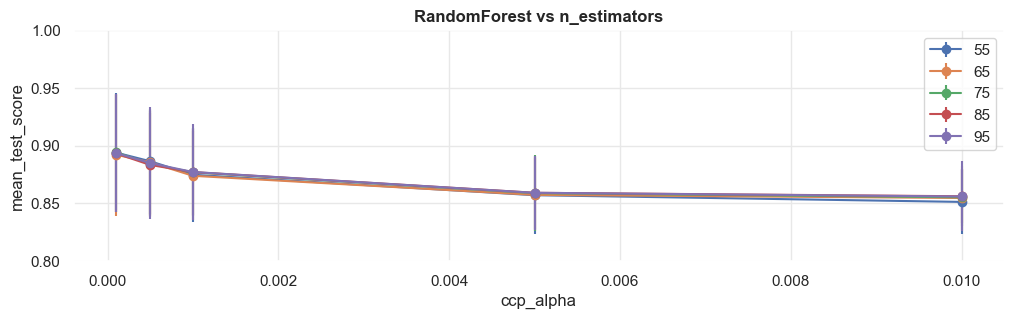

In [103]:
# Random Forest
comparar_acuracia_e_desvio_2('RandomForest','ccp_alpha','n_estimators')

<AxesSubplot:title={'center':'XGB vs max_depth'}, xlabel='eta', ylabel='mean_test_score'>

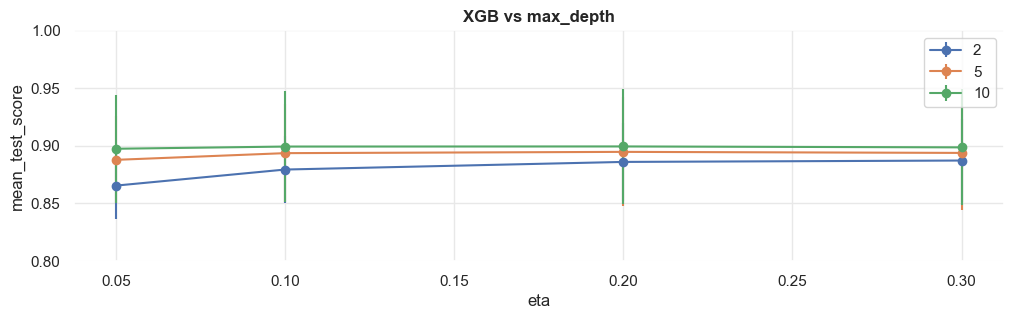

In [104]:
# XGBoost
comparar_acuracia_e_desvio_2('XGB','eta','max_depth')

<AxesSubplot:title={'center':'XGB vs max_depth'}, xlabel='colsample_bytree', ylabel='mean_test_score'>

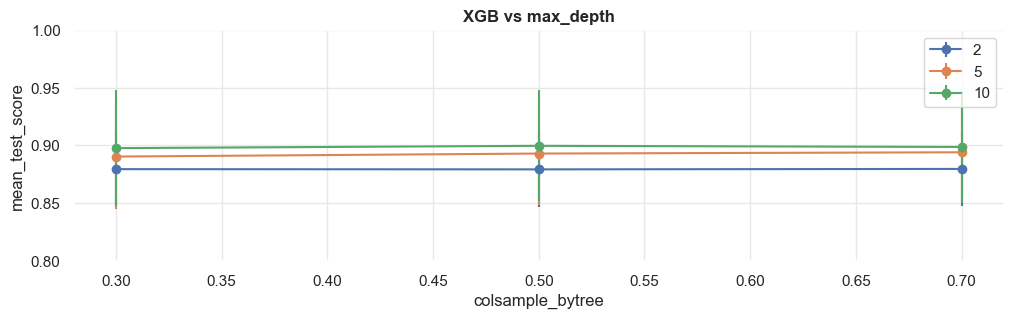

In [105]:
# XGBoost
comparar_acuracia_e_desvio_2('XGB','colsample_bytree','max_depth')

<AxesSubplot:title={'center':'XGB vs max_depth'}, xlabel='gamma', ylabel='mean_test_score'>

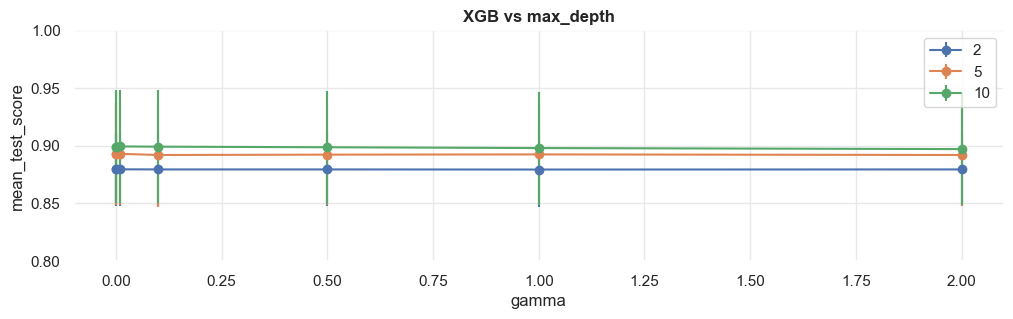

In [106]:
# XGBoost
comparar_acuracia_e_desvio_2('XGB','gamma','max_depth')

### Melhores Hiperparâmetros da 3ª Rodada do GridSearchCV - valores próximos aos melhores escolhidos

##### Árvore de Decisão (86,2%)
- criterion = 'entropy'
- ccp_alpha = 0.001

##### Random Forest (89,4%)
- ccp_alpha = 0.0001
- n_estimators = 95

##### XGBoost (90,0%)
- max_depth = 5
- eta = 0.3
- gamma = 0.01
- colsample_bytree = 0.7

### Árvore de Decisão <a class="anchor" id="subtitulo_5.2.1"></a>

#### Treino e Testagem do Modelo com Hiperparâmetros Selecionados

DecisionTreeClassifier(ccp_alpha=0.001, criterion='entropy')
Resultados da base de teste:
Teste: ROC_AUC =  0.8153
Teste: accuracy =  0.8472
Teste: precision =  0.7260
Teste: recall =  0.7415
Teste: f1 =  0.7337

Matriz de Confusão (Atual (lin) vs Previsto (col):
      0    1
0  1259  157
1   145  416

Curva ROC


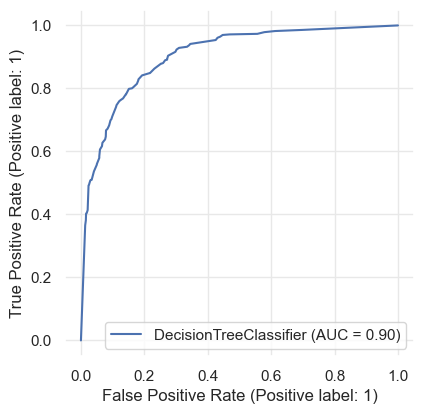

In [111]:
# Melhores hiperparâmetros

criterion = 'entropy'
ccp_alpha = 0.001

# Treino e scoragem da base de teste
model_dtree_otimizado = DecisionTreeClassifier(criterion = criterion,
                                                   ccp_alpha=ccp_alpha)
print(model_dtree_otimizado)
model_dtree_otimizado.fit(X_train, y_train)
pred_dtree_otimizado = model_dtree_otimizado.predict(X_test)

# Medidores de performance do modelo
print("Resultados da base de teste:")
auc_dtree = roc_auc_score(y_test, pred_dtree_otimizado) 
print(f'Teste: ROC_AUC = {auc_dtree: .4f}')
acc_dtree = accuracy_score(y_test, pred_dtree_otimizado)
print(f'Teste: accuracy = {acc_dtree: .4f}')
prec_dtree = precision_score(y_test, pred_dtree_otimizado)
print(f'Teste: precision = {prec_dtree: .4f}')
reca_dtree = recall_score(y_test, pred_dtree_otimizado)
print(f'Teste: recall = {reca_dtree: .4f}')
f1_dtree = f1_score(y_test, pred_dtree_otimizado)
print(f'Teste: f1 = {f1_dtree: .4f}')
# print("Classification report:")
# print(classification_report(y_test, pred_dtree_otimizado))

# Matriz de confusão
print('\nMatriz de Confusão (Atual (lin) vs Previsto (col):')
print(pd.DataFrame(confusion_matrix(y_test, pred_dtree_otimizado)))

# Curva ROC
print('\nCurva ROC')
sb.set(rc={'figure.figsize':(4.5,4.5)})
sb.set(rc={'axes.facecolor':'white', 'grid.color': '.91'})
plot_roc_curve(model_dtree_otimizado, X_test, y_test)
plt.show()

#### Importância das Variáveis

In [91]:
perm = PermutationImportance(model_dtree_otimizado, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0686 ± 0.0079,contract_Two Year
0.0576 ± 0.0082,number_of_referrals
0.0553 ± 0.0062,contract_One Year
0.0349 ± 0.0045,tenure_in_months
0.0124 ± 0.0022,age
0.0095 ± 0.0068,number_of_dependents
0.0070 ± 0.0094,payment_method_Credit Card
0.0049 ± 0.0045,paperless_billing
0.0026 ± 0.0068,online_security
0.0015 ± 0.0074,monthly_charge


#### Avaliar modelo com otimização e variáveis mais importantes?

### Random Forest <a class="anchor" id="subtitulo_5.2.2"></a>

### 🔴 <font color='red'>IMPORTANTE</font>
- 

#### Treino e Testagem do Modelo com Hiperparâmetros Selecionados

RandomForestClassifier(ccp_alpha=0.001, n_estimators=75)
Resultados da base de teste:
Teste: ROC_AUC =  0.8237
Teste: accuracy =  0.8538
Teste: precision =  0.7369
Teste: recall =  0.7540
Teste: f1 =  0.7454

Matriz de Confusão (Atual (lin) vs Previsto (col):
      0    1
0  1265  151
1   138  423

Curva ROC


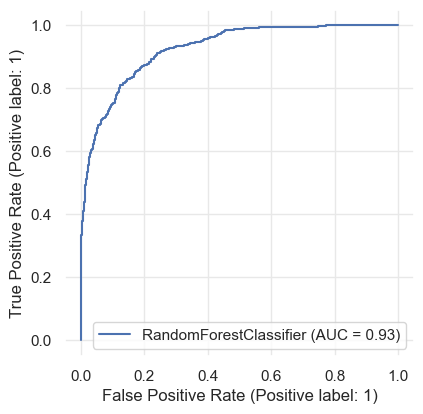

In [92]:
# Melhores hiperparâmetros
ccp_alpha = 0.0001
n_estimators = 95

# Treino e scoragem da base de teste
model_rforest_otimizado = RandomForestClassifier(ccp_alpha = ccp_alpha,
                                                 n_estimators = n_estimators)
print(model_rforest_otimizado)
model_rforest_otimizado.fit(X_train, y_train)
pred_rforest_otimizado = model_rforest_otimizado.predict(X_test)

# Medidores de performance do modelo
print("Resultados da base de teste:")
auc_rforest = roc_auc_score(y_test, pred_rforest_otimizado) 
print(f'Teste: ROC_AUC = {auc_rforest: .4f}')
acc_rforest = accuracy_score(y_test, pred_rforest_otimizado)
print(f'Teste: accuracy = {acc_rforest: .4f}')
prec_rforest = precision_score(y_test, pred_rforest_otimizado)
print(f'Teste: precision = {prec_rforest: .4f}')
reca_rforest = recall_score(y_test, pred_rforest_otimizado)
print(f'Teste: recall = {reca_rforest: .4f}')
f1_rforest = f1_score(y_test, pred_rforest_otimizado)
print(f'Teste: f1 = {f1_rforest: .4f}')
#print("Classification report:")
#print(classification_report(y_test, pred_rforest_otimizado))

# Matriz de confusão
print('\nMatriz de Confusão (Atual (lin) vs Previsto (col):')
print(pd.DataFrame(confusion_matrix(y_test, pred_rforest_otimizado)))

# Curva ROC
print('\nCurva ROC')
sb.set(rc={'figure.figsize':(4.5,4.5)})
sb.set(rc={'axes.facecolor':'white', 'grid.color': '.91'})
plot_roc_curve(model_rforest_otimizado, X_test, y_test)
plt.show()

#### Importância das Variáveis

In [93]:
perm = PermutationImportance(model_rforest_otimizado, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0269 ± 0.0088,contract_Two Year
0.0189 ± 0.0086,number_of_referrals
0.0179 ± 0.0037,contract_One Year
0.0101 ± 0.0070,number_of_dependents
0.0014 ± 0.0079,tenure_in_months
0.0014 ± 0.0073,online_security
0.0003 ± 0.0005,streaming_music
0.0003 ± 0.0065,premium_tech_support
0 ± 0.0000,city_San Diego
0.0000 ± 0.0018,internet_type_Fiber Optic


#### Avaliar modelo com otimização e variáveis mais importantes

### XGBoost <a class="anchor" id="subtitulo_5.2.3"></a>

### 🔴 <font color='red'>IMPORTANTE</font>
- Excluir hiperparâmetro min_child_weight
- Alterar eta para apenas .1, .01, .001
- Pesquisar em blogs utilizações do XGBoost

#### Treino e Testagem do Modelo com Hiperparâmetros Selecionados

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=0.01, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)


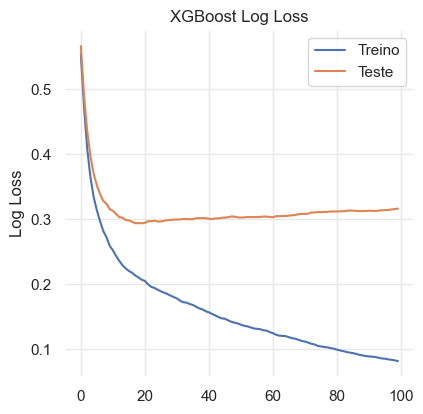

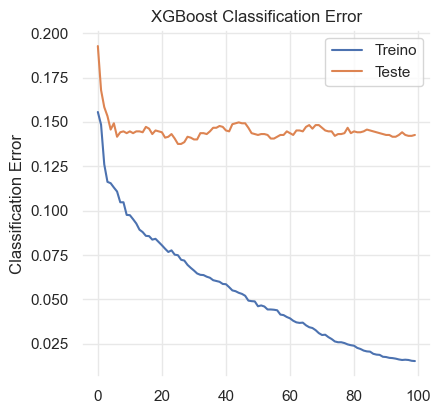

In [122]:
# Melhores variáveis e hiperparâmetros sem early stopping
max_depth = 5
eta = 0.3
gamma = 0.01
colsample_bytree = 0.7
n_estimators = 100

# Treino e scoragem da base de teste
model_xgboost_otimizado = XGBClassifier(max_depth = max_depth,
                                            eta = eta,
                                            gamma = gamma,
                                            colsample_bytree = colsample_bytree,
                                            n_estimators = n_estimators)
print(model_xgboost_otimizado)

# Ajustar curvas de aprendizado
eval_set = [(X_train, y_train), (X_test, y_test)]
model_xgboost_otimizado.fit(X_train, y_train,
                            eval_metric=['error','logloss'],
                            eval_set=eval_set,
                            verbose=False)
# model_xgboost_otimizado.fit(X_train, y_train)
pred_xgboost_otimizado = model_xgboost_otimizado.predict(X_test)

# Criar gráficos com as curvas de aprendizado
results = model_xgboost_otimizado.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

# Personalização dos gráficos
sb.set(style='darkgrid')
sb.set(rc={'figure.figsize':(4.5,4.5)})
sb.set(rc={'axes.facecolor':'white', 'grid.color': '.91'})

# Log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Treino')
ax.plot(x_axis, results['validation_1']['logloss'], label='Teste')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

# Classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Treino')
ax.plot(x_axis, results['validation_1']['error'], label='Teste')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=0.01, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)


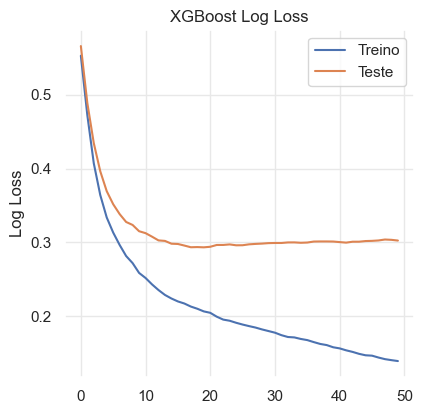

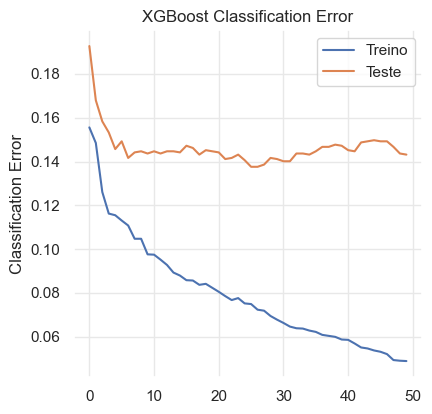

In [123]:
# Melhores variáveis e hiperparâmetros
max_depth = 5
eta = 0.3
gamma = 0.01
colsample_bytree = 0.7
n_estimators = 100

# Treino e scoragem da base de teste
model_xgboost_otimizado = XGBClassifier(max_depth = max_depth,
                                            eta = eta,
                                            gamma = gamma,
                                            colsample_bytree = colsample_bytree,
                                            n_estimators = n_estimators)
print(model_xgboost_otimizado)

# Ajustar curvas de aprendizado
eval_set = [(X_train, y_train), (X_test, y_test)]
model_xgboost_otimizado.fit(X_train, y_train,
                            early_stopping_rounds=30,
                            eval_metric=['error','logloss'],
                            eval_set=eval_set,
                            verbose=False)
# model_xgboost_otimizado.fit(X_train, y_train)
pred_xgboost_otimizado = model_xgboost_otimizado.predict(X_test)

# Criar gráficos com as curvas de aprendizado
results = model_xgboost_otimizado.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

# Personalização dos gráficos
sb.set(style='darkgrid')
sb.set(rc={'figure.figsize':(4.5,4.5)})
sb.set(rc={'axes.facecolor':'white', 'grid.color': '.91'})

# Log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Treino')
ax.plot(x_axis, results['validation_1']['logloss'], label='Teste')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

# Classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Treino')
ax.plot(x_axis, results['validation_1']['error'], label='Teste')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

Resultados da base de teste:
Teste: ROC_AUC =  0.8355
Teste: accuracy =  0.8553
Teste: precision =  0.7250
Teste: recall =  0.7897
Teste: f1 =  0.7560

Matriz de Confusão (Atual (lin) vs Previsto (col):
      0    1
0  1248  168
1   118  443

Curva ROC


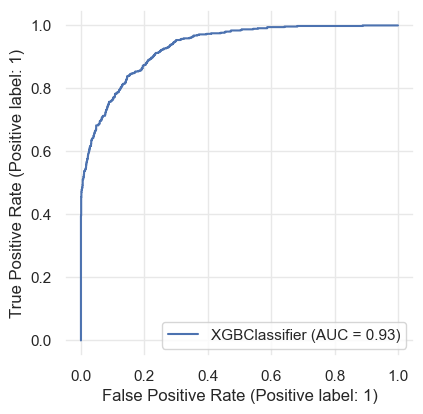

In [124]:
# Medidores de performance do modelo
print("Resultados da base de teste:")
auc_xgboost = roc_auc_score(y_test, pred_xgboost_otimizado) 
print(f'Teste: ROC_AUC = {auc_xgboost: .4f}')
acc_xgboost = accuracy_score(y_test, pred_xgboost_otimizado)
print(f'Teste: accuracy = {acc_xgboost: .4f}')
prec_xgboost = precision_score(y_test, pred_xgboost_otimizado)
print(f'Teste: precision = {prec_xgboost: .4f}')
reca_xgboost = recall_score(y_test, pred_xgboost_otimizado)
print(f'Teste: recall = {reca_xgboost: .4f}')
f1_xgboost = f1_score(y_test, pred_xgboost_otimizado)
print(f'Teste: f1 = {f1_xgboost: .4f}')
#print("Classification report:")
#print(classification_report(y_test, pred_xgboost_otimizado))

# Matriz de confusão
print('\nMatriz de Confusão (Atual (lin) vs Previsto (col):')
print(pd.DataFrame(confusion_matrix(y_test, pred_xgboost_otimizado)))

# Curva ROC
print('\nCurva ROC')
sb.set(rc={'figure.figsize':(4.5,4.5)})
sb.set(rc={'axes.facecolor':'white', 'grid.color': '.91'})
plot_roc_curve(model_xgboost_otimizado, X_test, y_test)
plt.show()

#### Importância das Variáveis

In [125]:
perm = PermutationImportance(model_xgboost_otimizado, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0564 ± 0.0089,tenure_in_months
0.0386 ± 0.0099,contract_Two Year
0.0349 ± 0.0076,number_of_referrals
0.0165 ± 0.0068,contract_One Year
0.0100 ± 0.0090,number_of_dependents
0.0037 ± 0.0020,age
0.0037 ± 0.0037,married
0.0021 ± 0.0073,payment_method_Credit Card
0.0020 ± 0.0019,monthly_charge
0.0020 ± 0.0018,streaming_music
